In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from typing import Tuple
from dataclasses import dataclass
import openpyxl
import os
import string
import logging
import configparser
import ast

import CleaningConfig as cf


: 

In [67]:
'''Setup logging'''

logger = logging.getLogger()
logger.handlers = []

# Set the desired log level
logger.setLevel(logging.DEBUG)

# Create a console handler and set its log level
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)

# Create a formatter and set it on the console handler
formatter = logging.Formatter('%(levelname)s: %(message)s')
console_handler.setFormatter(formatter)

# Add the console handler to the logger
logger.addHandler(console_handler)


In [68]:
'''Class about reading info from config file'''

class ConfigFileReader():
    '''This class gets info from config file and turns it into string type, stored in a dict'''

    def obtain_info_from_config(self):
        '''Get info from config.ini file'''

        code_path = r'C:\consumables_cleaning\astronaut\cleaning'
        os.chdir(code_path)

        list_of_files        = os.listdir()
        config_file_extension= '.ini'

        config_file_list = [item for item in list_of_files if config_file_extension in item]
        config_file      = ''.join(config_file_list)
        config_parser    = configparser.ConfigParser()
        config_parser.read(config_file)

        # Extract info from config file AS STRING
        file_section           = 'File'
        filename_str           = config_parser.get(file_section, 'filename')
        location_str           = config_parser.get(file_section, 'location')

        columns_section        = 'Columns'
        temperature_column_str = config_parser.get(columns_section, 'temperature_column')
        conductivity_column_str= config_parser.get(columns_section, 'conductivity_column')
        flow_column_str        = config_parser.get(columns_section, 'flow_column')
        time_column_str        = config_parser.get(columns_section, 'time_column')

        types_section          = 'Types'
        alkaline_keyword_str   = config_parser.get(types_section, 'alkaline_keyword')
        acid_keyword_str       = config_parser.get(types_section, 'acid_keyword')
        other_keyword_str      = config_parser.get(types_section, 'other_keyword')

        constants_section      = 'Constants'
        T_crit_str             = config_parser.get(constants_section, 'T_crit')
        time_crit_str          = config_parser.get(constants_section, 'time_crit')
        sigma_alkaline_str     = config_parser.get(constants_section, 'sigma_alkaline')
        sigma_acid_str         = config_parser.get(constants_section, 'sigma_acid')
        sigma_other_str        = config_parser.get(constants_section, 'sigma_other')
        t_cond_water_str       = config_parser.get(constants_section, 't_cond_water')

        logger.info("Successfully obtained info from config.ini file")

        config_info_str = { 
                          'filename_str':            filename_str,
                          'location_str':            location_str,
                          'temperature_column_str':  temperature_column_str,
                          'conductivity_column_str': conductivity_column_str,
                          'flow_column_str':         flow_column_str,
                          'time_column_str':         time_column_str,
                          'alkaline_keyword_str':    alkaline_keyword_str,
                          'acid_keyword_str':        acid_keyword_str,
                          'other_keyword_str':       other_keyword_str,
                          'T_crit_str':              T_crit_str,
                          'time_crit_str':           time_crit_str,
                          'sigma_alkaline_str':      sigma_alkaline_str,
                          'sigma_acid_str':          sigma_acid_str,
                          'sigma_other_str':         sigma_other_str,
                          't_cond_water_str':        t_cond_water_str,
                          }

        return config_info_str

    def revert_config_info_type_from_str(self):
        '''Convert to literal type from STRING'''
        
        config_info_str = self.obtain_info_from_config()

        try:
            filename            = ast.literal_eval(config_info_str['filename_str'])
            location            = ast.literal_eval(config_info_str['location_str'])
            temperature_column  = ast.literal_eval(config_info_str['temperature_column_str'])
            conductivity_column = ast.literal_eval(config_info_str['conductivity_column_str'])
            flow_column         = ast.literal_eval(config_info_str['flow_column_str'])
            time_column         = ast.literal_eval(config_info_str['time_column_str'])
            alkaline_keyword    = ast.literal_eval(config_info_str['alkaline_keyword_str'])
            acid_keyword        = ast.literal_eval(config_info_str['acid_keyword_str'])
            other_keyword       = ast.literal_eval(config_info_str['other_keyword_str'])
            T_crit              = ast.literal_eval(config_info_str['T_crit_str'])
            time_crit           = ast.literal_eval(config_info_str['time_crit_str'])
            sigma_alkaline      = ast.literal_eval(config_info_str['sigma_alkaline_str'])
            sigma_acid          = ast.literal_eval(config_info_str['sigma_acid_str'])
            sigma_other         = ast.literal_eval(config_info_str['sigma_other_str'])
            t_cond_water        = ast.literal_eval(config_info_str['t_cond_water_str'])

            logger.info("Successfully turned config file into string type")

        except: # if something goes wrong, ie: cannot find file
            filename            = "20230413_acid 2.0_Raats.csv"
            location            = "C:\\consumables_cleaning\\input\\"
            temperature_column  = '4AI 1043 - Temperature [°C]'
            conductivity_column = 'bueS-X-Gateway - Cond_compensated [mS/cm]'
            flow_column         = 'bueS-X-Gateway - Flow_switched [l/min]'
            time_column         = 'Time'
            alkaline_keyword    = 'alkaline'
            acid_keyword        = 'acid'
            other_keyword       = 'other'
            T_crit              = 72
            time_crit           = 120
            sigma_alkaline      = 23.6
            sigma_acid          = 7.24
            sigma_other         = 30
            t_cond_water        = 20

            logger.error("Cannot access .ini file, using manual input")
            logger.error("Make sure there is NO single %% sign at once")

        config_info = { 
                      'filename':         filename,
                      'location':         location,
                      'T_column_name':    temperature_column,
                      'C_column_name':    conductivity_column,
                      'F_column_name':    flow_column,
                      'time_column_name': time_column,
                      'alkaline_keyword': alkaline_keyword,
                      'acid_keyword':     acid_keyword,
                      'other_keyword':    other_keyword,
                      'T_crit':           T_crit,
                      'time_interval':    time_crit,
                      'sigma_alkaline':   sigma_alkaline,
                      'sigma_acid':       sigma_acid,
                      'sigma_other':      sigma_other,
                      't_cond_water':     t_cond_water,
                      }
        
        return config_info


class Dict2ClassConverter:
    '''This class gets info from the last class (in dict) and converts its info to class'''

    def __init__(self, dictionary):
        self.__dict__.update(dictionary)



In [69]:
'''Run the code'''

config_file_reader = ConfigFileReader()
config_info_str         = config_file_reader.obtain_info_from_config()
config_info             = config_file_reader.revert_config_info_type_from_str()

Constants                   = Dict2ClassConverter(config_info)
list_of_config_variables= [name for name in dir(Constants) if not callable(getattr(Constants, name)) and not name.startswith('__')]

logger.info(f"========================")
logger.info(f"List of variables: ")
logger.info(list_of_config_variables)
logger.info(f"========================")
logger.info(f"File name: {Constants.filename}")
logger.info(f"File location: {Constants.location}")
logger.info(f"Columns: {Constants.T_column_name} | {Constants.C_column_name} | {Constants.F_column_name}, {Constants.time_column_name}")
logger.info(f"T crit [C]: {Constants.T_crit}")
logger.info(f"t crit [s]: {Constants.time_interval}")
logger.info(f"Sigma [mS/cm]: {Constants.sigma_alkaline} (alkaline), {Constants.sigma_acid} (acid), {Constants.sigma_other} (other)")
logger.info(f"Time crit water [s]: {Constants.t_cond_water}")


INFO: Successfully obtained info from config.ini file
INFO: Successfully obtained info from config.ini file
INFO: Successfully turned config file into string type
INFO: ========================
INFO: List of variables: 
INFO: ['C_column_name', 'F_column_name', 'T_column_name', 'T_crit', 'acid_keyword', 'alkaline_keyword', 'filename', 'location', 'other_keyword', 'sigma_acid', 'sigma_alkaline', 'sigma_other', 't_cond_water', 'time_column_name', 'time_interval']
INFO: ========================
INFO: File name: 20230413_acid 2.0_Raats.csv
INFO: File location: C:\consumables_cleaning\input\
INFO: Columns: 4AI 1043 - Temperature [Â°C] | bueS-X-Gateway - Cond_compensated [mS/cm] | bueS-X-Gateway - Flow_switched [l/min], Time
INFO: T crit [C]: 72.0
INFO: t crit [s]: 120
INFO: Sigma [mS/cm]: 23.6 (alkaline), 7.24 (acid), 31.0 (other)
INFO: Time crit water [s]: 20


In [70]:
class DfConstants:
    '''Class of 'Constants' where we keep dataframe constants'''

    excel_temperature_column = '4AI 1043 - Temperature [°C]'
    excel_conductivity_column= 'bueS-X-Gateway - Cond_compensated [mS/cm]' #Constants.C_column_name
    excel_flow_column        = 'bueS-X-Gateway - Flow_switched [l/min]' #Constants.F_column_name
    excel_time_column        = 'Time' # Constants.time_column_name

    df_time_column           = 'Time [RT]'
    df_temperature_column    = 'Temperature [C]'
    df_conductivity_column   = 'Conductivity [mS/cm]'
    df_flow_column           = 'Flow [L/min]'

    time_substring           = 'time'
    temperature_substring    = 'temp'
    conductivity_substring   = 'cond'
    flow_substring           = 'flow'


In [71]:
'''Cell containing class that converts csv to usable DataFrame'''

class csvToDataframeMaker:
    '''Gets data to dataframe, then keeps relevant columns (T, C, F) only'''

    def save_data_in_dataframe(self, filename) -> pd.core.frame.DataFrame:
        '''Read csv data of a certain file and save into pandas dataframe
        Input: filename (name of desired file)
        Output: dataframe of read file'''
        df = pd.read_csv(filename,
                         sep        = ";",
                         decimal    = ",",
                         quotechar  = "\"",
                         parse_dates= ["Time"])
        # df = df.set_index('Time') # Turns the nameless index column into a "Time" column

        input_dataframe: pd.core.frame.DataFrame = df
        return input_dataframe

    def make_dataframe_of_relevant_columns(self, input_dataframe) -> pd.core.frame.DataFrame:
        '''Makes new DataFrame of the relevant columns
        Input:  dataframe of the input csv file, contains all data
        Output: dataframe of the input csv file, contains relevant data only (time, T, C, F)'''

        relevant_columns   = [DfConstants.excel_time_column,
                              DfConstants.excel_temperature_column, 
                              DfConstants.excel_conductivity_column,
                              DfConstants.excel_flow_column]

        new_column_names   = {DfConstants.excel_time_column:         DfConstants.df_time_column,
                              DfConstants.excel_temperature_column:  DfConstants.df_temperature_column,
                              DfConstants.excel_conductivity_column: DfConstants.df_conductivity_column,
                              DfConstants.excel_flow_column:         DfConstants.df_flow_column}

        relevant_dataframe = input_dataframe[relevant_columns]
        output_dataframe   = relevant_dataframe.rename(columns = new_column_names)

        return output_dataframe

    def obtain_solution_type_from_filename(self, config_info):
        '''Get solution type from file name'''

        if config_info['alkaline_keyword'] in Constants.filename:
            solution_type = config_info['alkaline_keyword']
            logger.info(f"Solution is {config_info['alkaline_keyword']}")

        elif config_info['acid_keyword'] in Constants.filename:
            solution_type = config_info['acid_keyword']
            logger.info(f"Solution is {config_info['acid_keyword']}")

        elif config_info['other_keyword'] in Constants.filename:
            solution_type = config_info['other_keyword']
            logger.info(f"Solution is {config_info['other_keyword']}")

        logger.info(f"File '{Constants.filename}' is of type '{solution_type}'")
        return solution_type


In [72]:
# Backup cell, to delete
# #Put the below in a class 'csvToDataframeMaker'

# '''Gets data to dataframe, then keeps relevant columns (T, C, F) only'''


# def save_data_in_dataframe(filename: str) -> pd.core.frame.DataFrame:
#     '''Read csv data of a certain file and save into pandas dataframe
#     Input:
#     filename: name of desired file
#     Output: dataframe of read file'''
#     df = pd.read_csv(filename,
#                      sep        = ";",
#                      decimal    = ",",
#                      quotechar  = "\"",
#                      parse_dates= ["Time"])
#     # df = df.set_index('Time') # Turns the nameless index column into a "Time" column
#     return df


# def make_dataframe_of_relevant_columns(input_dataframe: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
#     '''Makes new DataFrame of the relevant columns
#     Input:  dataframe of the input csv file, contains all data
#     Output: dataframe of the input csv file, contains relevant data only (time, T, C, F)'''

#     temperature_column  = '4AI 1043 - Temperature [°C]' #Constants.T_column_name
#     conductivity_column = 'bueS-X-Gateway - Cond_compensated [mS/cm]' #Constants.C_column_name
#     flow_column         = 'bueS-X-Gateway - Flow_switched [l/min]' #Constants.F_column_name
#     time_column         = 'Time' # Constants.time_column_name

#     relevant_columns    = [time_column, temperature_column, conductivity_column, flow_column]
#     relevant_dataframe  = input_dataframe[relevant_columns]

#     new_column_names    = {time_column:         'Time [RT]',
#                            temperature_column:  'Temperature [C]',
#                            conductivity_column: 'Conductivity [mS/cm]',
#                            flow_column:         'Flow [L/min]'}
    
#     output_dataframe    = relevant_dataframe.rename(columns = new_column_names)

#     return output_dataframe


# def obtain_solution_type_from_filename():
#     '''Get solution type from file name'''

#     if config_info['alkaline_keyword'] in Constants.filename:
#         solution_type = config_info['alkaline_keyword']
#         logger.info(f"Solution is {config_info['alkaline_keyword']}")

#     elif config_info['acid_keyword'] in Constants.filename:
#         solution_type = config_info['acid_keyword']
#         logger.info(f"Solution is {config_info['acid_keyword']}")

#     elif config_info['other_keyword'] in Constants.filename:
#         solution_type = config_info['other_keyword']
#         logger.info(f"Solution is {config_info['other_keyword']}")

#     logger.info(f"File '{Constants.filename}' is of type '{solution_type}'")
#     return solution_type

# solution_type = obtain_solution_type_from_filename()


In [73]:
'''Class containing reusable function to find column names'''

class ColumnFinder:
    '''Contains function that gives the usable columns, like T-C-F'''

    def df_column_finder(df):
        '''Gets column indices based on keywords of desired parameters T/C/F
        INPUT: dataframe
        OUTPUT: list of column # which contain the desired keywords'''

        lowercase_columns = df.columns.str.lower()

        time_column_index = np.where(lowercase_columns.str.contains(DfConstants.time_substring))[0][0]
        temp_column_index = np.where(lowercase_columns.str.contains(DfConstants.temperature_substring))[0][0]
        cond_column_index = np.where(lowercase_columns.str.contains(DfConstants.conductivity_substring))[0][0]
        flow_column_index = np.where(lowercase_columns.str.contains(DfConstants.flow_substring))[0][0]

        usable_columns_indices = [temp_column_index, cond_column_index, flow_column_index]

        return time_column_index, usable_columns_indices


In [74]:
class DataCleaner:
    '''Class that fills gaps in data, smoothens data, then makes derivatives of data and clips these derivatives'''

    def fill_data_gaps(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        '''Fills the NaN gaps in data without removing entries
        Input: dataframe containing [time, T, C, F] data
        Output: dataframe without NaN values'''

        df_filled = df.copy()

        time_column_id    = df.columns.get_loc(DfConstants.df_time_column)
        number_of_columns = df_filled.shape[1]
       
        # Possibilities to close data gaps: ffill, bfill, dropna, interpolate(linear/spline/polynomial), fillna, fillna(mean), rolling
        for i in range(time_column_id + 1, number_of_columns):
            df_filled.iloc[:, i] = df.iloc[:, i].fillna(method = 'bfill')

            # Handling NaN of a column's LAST value:
            if pd.isna(df_filled.iloc[-1, i]):
                last_non_null_value   = df_filled.iloc[:, i].dropna().iloc[-1]
                df_filled.iloc[-1, i] = last_non_null_value

        return df_filled

    def smoothen_data(df: pd.core.frame.DataFrame, window_size: int = 5) -> pd.core.frame.DataFrame:
        '''Smoothens the data per column (temp, cond, flow)
        INPUT: dataframe containing [time, T, C, F] data
        window_size: how big is the averaging window. Somewhere between 3-5 is good'''

        df_smooth         = df.copy()

        time_column_id    = df.columns.get_loc(DfConstants.df_time_column)
        number_of_columns = df_smooth.shape[1]

        for i in range(time_column_id + 1, number_of_columns):
            df_smooth.iloc[:, i] = df.iloc[:, i].rolling(window_size, min_periods = 1).mean()

        return df_smooth

    def make_derivatives(df: pd.core.frame.DataFrame, dx: int = 1) -> pd.core.frame.DataFrame:
        '''Computes 1st and 2nd derivative of dataframe
        INPUT:
              - df: input dataframe
              - dx: spacing for differentiation, set to 1
        OUTPUT: 2 Dataframes with derived values, one for the 1st derivative, one for the 2nd derivative,
        having columns [time, temp, cond, flow]'''

        df_diff  = df.copy() # 1st derivative
        df_diff2 = df.copy() # 2nd derivative

        time_column_id       = df.columns.get_loc(DfConstants.df_time_column)
        number_of_columns    = df_diff.shape[1]
        coeff_to_offset_diff = -4 # offsets differentiation

        for i in range(time_column_id + 1, number_of_columns):
            df_diff.iloc[:, i]  = np.gradient(df.iloc[:, i], dx) # 1st derivative
            df_diff2.iloc[:, i] = np.gradient(df_diff.iloc[:, i], dx) # 2nd derivative

            # Every instance of differentiation causes an offset. Should be countered
            df_diff.iloc[:, i]  = np.roll(df_diff.iloc[:, i], coeff_to_offset_diff)
            df_diff2.iloc[:, i] = np.roll(df_diff2.iloc[:, i], coeff_to_offset_diff)
        
        return df_diff, df_diff2

    def clip_derivatives(df_diff: pd.core.frame.DataFrame, criterion: float = 0.005) -> pd.core.frame.DataFrame:
        '''Clipper functionality: if derivative is +ve and below X% of the max derivative value, 
        make it negative. This will make the derivative processing easier by getting rid of small bumps
        INPUT:
        - derivative dataframe
        - criterion: best interpreted as 'below which fraction of the max value do we neglect values?'
        OUTPUT: derivative dataframe with flipped small values'''

        dYdx = df_diff.copy()

        # criterion: float = 0.005 # below which fraction of the max value do we neglect values?
        time_column_id   = df_diff.columns.get_loc(DfConstants.df_time_column)
        num_of_columns   = dYdx.shape[1]
        dY_max           = np.zeros(num_of_columns)

        for column in range(time_column_id + 1, num_of_columns):
            dY_max[column] = dYdx.iloc[:, column].max()
            for i, val in enumerate( dYdx.iloc[:, column] ):
                if (val < (criterion * dY_max[column])) & (val > 0): # if derivative is +ve AND below X% of the max derivative value
                    dYdx.iloc[i, column] = val * -1
        return dYdx


In [75]:
# '''[backup, delete when class is working] Fill gaps in data, then smoothen data'''

# def fill_data_gaps(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
#     '''Fills the NaN gaps in data without removing entries
#     Input: dataframe containing [time, T, C, F] data
#     Output: dataframe without NaN values'''

#     df_filled = df.copy()

#     time_column_id    = 1
#     number_of_columns = df_filled.shape[1]

#     # How to close gaps in data? Possibilities: ffill, bfill, dropna, interpolate(linear/spline/polynomial), fillna, fillna(mean), rolling
#     for i in range(time_column_id, number_of_columns):
#         df_filled.iloc[:, i] = df.iloc[:, i].fillna(method = 'bfill')

#         # How to handle NaN of a column's LAST value:
#         if pd.isna( df_filled.iloc[-1, i] ):
#             last_non_null_value   = df_filled.iloc[:, i].dropna().iloc[-1]
#             df_filled.iloc[-1, i] = last_non_null_value

#     # output_unsmooth[output_unsmooth.isna()]
#     return df_filled


# def smoothen_data(df: pd.core.frame.DataFrame, window_size: int = 5) -> pd.core.frame.DataFrame:
#     '''Smoothens the data per column (temp, cond, flow)
#     INPUT: dataframe containing [time, T, C, F] data
#     window_size: how big is the averaging window. Somewhere between 3-5 is good'''

#     df_smooth         = df.copy()

#     time_column_id    = 1
#     number_of_columns = df_smooth.shape[1]

#     for i in range(time_column_id, number_of_columns):
#         df_smooth.iloc[:, i] = df.iloc[:, i].rolling(window_size, min_periods = 1).mean()

#     return df_smooth


# # =============

# '''Make derivatives and clip them'''

# def make_derivatives(df: pd.core.frame.DataFrame, dx: int = 1) -> pd.core.frame.DataFrame:
#     '''Computes 1st and 2nd derivative of dataframe
#     INPUT:
#     df: input dataframe
#     dx: spacing for differentiation, set to 1
#     OUTPUT: Dataframe with derived values'''

#     df_diff  = df.copy() # 1st derivative
#     df_diff2 = df.copy() # 2nd derivative

#     time_column_id       = 1
#     number_of_columns    = df_diff.shape[1]
#     coeff_to_offset_diff = -4 # offsets differentiation

#     for i in range(time_column_id, number_of_columns):
#         df_diff.iloc[:, i]  = np.gradient(df.iloc[:, i], dx) # 1st derivative
#         df_diff2.iloc[:, i] = np.gradient(df_diff.iloc[:, i], dx) # 2nd derivative

#         # Every instance of differentiation causes an offset. Should be countered
#         df_diff.iloc[:, i]  = np.roll(df_diff.iloc[:, i], coeff_to_offset_diff)
#         df_diff2.iloc[:, i] = np.roll(df_diff2.iloc[:, i], coeff_to_offset_diff)
    
#     return df_diff, df_diff2


# def clip_derivatives(df_diff: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
#     '''Clipper functionality: if derivative is +ve and below X% of the max derivative value, 
#     make it negative. This will make the derivative processing easier by getting rid of small bumps
#     INPUT: derivative dataframe
#     OUTPUT: derivative dataframe with flipped small values'''

#     dYdx   = df_diff.copy()

#     crit: float    = 0.005 # below which fraction of the max value do we neglect values?
#     time_column_id = 1
#     num_of_columns = dYdx.shape[1]
#     dY_max         = np.zeros(num_of_columns)

#     for column in range(time_column_id, num_of_columns):
#         dY_max[column] = dYdx.iloc[:, column].max()
#         for i, val in enumerate( dYdx.iloc[:, column] ):
#             if (val < (crit * dY_max[column])) & (val > 0): # if derivative is +ve and below X% of the max derivative value
#                 dYdx.iloc[i, column] = val * -1
#     return dYdx



In [76]:
'''Make TemperatureKPIObtainer() class'''

class TemperatureKPIObtainer():
    '''Gets relative and absolute points of TEMPERATURE T, because temperature has lots of KPIs associated with it
    INPUT:
    df: input dataframe
    comparison_order: points to consider on each side of comparison to determine whether point is relative min/max, 30 is a good value
    OUTPUT: dictionary of relative points'''
    
    def __init__(self, df: pd.core.frame.DataFrame):
        self.df = df
        self.time_column_idx = 0  # should be 0 (or the DataFrame index) usually

    def make_temperature_df(self):
        '''Setup function that takes the input DataFrame and outputs a DataFrame of temperature and its column #
        INPUT: Standard DataFrame
        OUTPUT: DataFrame consisting of only the time and temperature points'''

        lowercase_columns = self.df.columns.str.lower()
        where_is_t_column = np.where(lowercase_columns.str.contains(DfConstants.time_substring))[0][0]
        if self.time_column_idx != where_is_t_column:
            logger.warning(f"The time column index (#{where_is_t_column}) is different than the expected column (#{self.time_column_idx})")

        temp_column_index = np.where(lowercase_columns.str.contains(DfConstants.temperature_substring))[0][0]
        temp_df           = self.df.iloc[:, :temp_column_index + 1]

        return temp_df, temp_column_index

    def calculate_temperature_relative_extrema(self, comparison_order: int = 30):
        '''Calculates the extrema points, like local minima and maxima, of temperature
        OUTPUT: df_temp_extrema, which is a DataFrame of Temperature extrema points'''

        temp_df, _ = TemperatureKPIObtainer.make_temperature_df(self)

        relative_min_idx     = argrelextrema(temp_df.values, np.less,    order = comparison_order)[0]
        relative_max_idx     = argrelextrema(temp_df.values, np.greater, order = comparison_order)[0]
        relative_min_time    = temp_df.iloc[relative_min_idx, self.time_column_idx]
        relative_max_time    = temp_df.iloc[relative_max_idx, self.time_column_idx]
        relative_min_values  = temp_df.iloc[relative_min_idx, -1] #temp is at last column
        relative_max_values  = temp_df.iloc[relative_max_idx, -1] #temp is at last column

        df_relative_min_idx  = pd.DataFrame(relative_min_idx,           columns=['Rel min index'])
        df_relative_max_idx  = pd.DataFrame(relative_max_idx,           columns=['Rel max index'])
        df_relative_min_time = pd.DataFrame(relative_min_time.values,   columns=['Time of rel min'])
        df_relative_max_time = pd.DataFrame(relative_max_time.values,   columns=['Time of rel max'])
        df_relative_min_value= pd.DataFrame(relative_min_values.values, columns=['Value of rel min'])
        df_relative_max_value= pd.DataFrame(relative_max_values.values, columns=['Value of rel max'])

        df_temp_extrema      = pd.concat([df_relative_min_idx, df_relative_min_time, df_relative_min_value,
                                          df_relative_max_idx, df_relative_max_time, df_relative_max_value,],
                                          axis = 1)
        return df_temp_extrema

    def calculate_temperature_absolute_extrema(self):
        '''Obtains the temperature keypoints
        Output: dictionary containing key temperature values like T_max and 2-min window wiht highest T'''

        temp_df, temp_column_index = TemperatureKPIObtainer.make_temperature_df(self)

        temp_column       = self.df.iloc[:, temp_column_index]
        T_max_value       = np.amax(temp_column)
        T_max_idx         = np.where(temp_column == T_max_value)[0][0]
        time_column_index = self.df.columns.get_loc(DfConstants.df_time_column)
        T_max_time        = temp_df.iloc[T_max_idx, time_column_index]

        T_criterion           = Constants.T_crit # set in the config file
        T_above_crit_idx      = np.where(temp_column > T_criterion)[0] # Temperature values above the crit
        T_above_crit_duration = len(T_above_crit_idx)              # time [s] where T > T_criterion (set in config file)

        # Get "avg. T of time interval with highest T [C]"
        time_interval_window       = Constants.time_interval
        T_moving_avg_time_interval = temp_column.rolling(time_interval_window).mean()
        T_of_max_time_interval     = np.amax(T_moving_avg_time_interval)

        max_temp_keypoints = {'T_max [C]':                               T_max_value,
                              'T_max idx [#]':                           T_max_idx,
                              'T_max time [s]':                          T_max_time,
                              'Index of T values above T_crit [#]':      T_above_crit_idx,
                              'Duration for which T > T_crit [s]':       T_above_crit_duration,
                              'T of max time interval [C]':              T_of_max_time_interval, }

        return max_temp_keypoints


In [77]:
'''Class that gets the peaks given a dataframe of the data'''

class FindDerivativePeaks():
    '''Function that finds the peaks of the 1st derivative
    INPUT:
    input_array: array of the desired property
    comparison_order: how many points before/after a point do we use to determine it is a local min/max? 30 is a nice value
    OUTPUT:
    dY_relative_max_idx: index of local maxima
    dY_relative_min_idx: index of local minima
    dY_max_idx: index of absolute maximum'''

    def __init__(self, df: pd.core.frame.DataFrame):
        self.df = df

    # remove if not used
    def setup(self):
        dYdx, _           = DataCleaner.make_derivatives(self.df) # Get derivatives
        lowercase_columns = dYdx.columns.str.lower()

        time_column_idx   = np.where(lowercase_columns.str.contains(DfConstants.time_substring))[0][0]
        temp_column_index = np.where(lowercase_columns.str.contains(DfConstants.temperature_substring))[0][0]
        cond_column_index = np.where(lowercase_columns.str.contains(DfConstants.conductivity_substring))[0][0]
        flow_column_index = np.where(lowercase_columns.str.contains(DfConstants.flow_substring))[0][0]

        usable_columns    = [temp_column_index, cond_column_index, flow_column_index]
        return time_column_idx, usable_columns


    def find_dY_absolute_extrema(self):
        '''This function aims to get the ABSOLUTE extrema points from the derivative (dY) dataframe, for each parameter (T, C, F)
        input: -
        output: properties_df, which is a list of dictionaries, each dictionary dealing with a parameter'''

        dYdx_df, _      = DataCleaner.make_derivatives(self.df) # Get derivatives
        time_column_idx, usable_columns = ColumnFinder.df_column_finder(dYdx_df) #FindDerivativePeaks.setup(self)

        list_of_properties_dict = []  # List to store dicts for each parameter
        for _, val in enumerate(usable_columns):

            # Get absolute maximum dY and its location
            dY_max_value= np.amax(dYdx_df.iloc[:, val])
            dY_max_idx  = np.where(dYdx_df == dY_max_value)[0][0]   # dYdx_df.iloc[:, val].idxmax()
            dY_max_time = self.df.iloc[dY_max_idx, time_column_idx] # df[dYdx == dY_max_value].index[0]

            # Get absolute minimum dY and its location
            dY_min_value= np.amin(dYdx_df.iloc[:, val])
            dY_min_idx  = np.where(dYdx_df == dY_min_value)[0][0]
            dY_min_time = self.df.iloc[dY_min_idx, time_column_idx]

            dY_extrema_dict = {'dY_max value':    dY_max_value,
                               'dY_max idx [#]':  dY_max_idx,
                               'dY_max time [s]': dY_max_time,
                               'dY_min value':    dY_min_value,
                               'dY_min idx [#]':  dY_min_idx,
                               'dY_min time [s]': dY_min_time, }
            
            list_of_properties_dict.append(dY_extrema_dict)

        return list_of_properties_dict


    def find_dY_relative_extrema(self, comparison_order: int = 30):
        '''This function aims to get the RELATIVE extrema points from the derivative (dY) dataframe, for each parameter (T, C, F)
        input: comparison_order, which is the # of neighboring points we compare to when deciding if we have a relative min/max
        output: properties_df, which is a list of dictionaries, each dictionary dealing with a parameter'''

        dYdx_df, _    = DataCleaner.make_derivatives(self.df) # Get derivatives
        time_column_idx, usable_columns = ColumnFinder.df_column_finder(dYdx_df)

        list_of_properties_df = []  # List to store the dataframes
        for _, val in enumerate(usable_columns):

            # When does the normal curve begin to drastically change? When its derivative changes
            dY_relative_max_idx     = argrelextrema(dYdx_df.iloc[:, val].values, np.greater, order = comparison_order)[0]  #it is offset due to differentiation
            dY_relative_min_idx     = argrelextrema(dYdx_df.iloc[:, val].values, np.less,    order = comparison_order)[0]

            dY_relative_max_time    = self.df.iloc[dY_relative_max_idx, time_column_idx] #df.index[dY_relative_max_idx]
            dY_relative_min_time    = self.df.iloc[dY_relative_min_idx, time_column_idx]

            dY_relative_max_value   = dYdx_df.values[dY_relative_max_idx, val] #dYdx.iloc[dY_relative_max_idx, 1]
            dY_relative_min_value   = dYdx_df.values[dY_relative_min_idx, val]

            df_dY_relative_min_idx  = pd.DataFrame(dY_relative_min_idx,         columns = ['Index of rel min'])
            df_dY_relative_min_time = pd.DataFrame(dY_relative_min_time.values, columns = ['Time of rel min'])
            df_dY_relative_min_value= pd.DataFrame(dY_relative_min_value,       columns = ['Rel min value'])
            df_dY_relative_max_idx  = pd.DataFrame(dY_relative_max_idx,         columns = ['Index of rel max'])
            df_dY_relative_max_time = pd.DataFrame(dY_relative_max_time.values, columns = ['Time of rel max'])
            df_dY_relative_max_value= pd.DataFrame(dY_relative_max_value,       columns = ['Rel max value'])

            df_dY_relative_extrema  = pd.concat([df_dY_relative_min_idx, df_dY_relative_min_time, df_dY_relative_min_value,
                                                 df_dY_relative_max_idx, df_dY_relative_max_time, df_dY_relative_max_value,],
                                                 axis = 1)

            df_dY_relative_extrema_no_NaN     = df_dY_relative_extrema.replace(np.nan, 0)
            df_dY_relative_extrema_no_NaN_NaT = df_dY_relative_extrema_no_NaN.replace(pd.NaT, 0)

            list_of_properties_df.append(df_dY_relative_extrema_no_NaN_NaT)

        return list_of_properties_df


In [78]:
'''Cell to run the code'''

filename            = Constants.filename
location            = Constants.location

os.chdir(location)
csv_to_df_maker= csvToDataframeMaker()
df                       = csv_to_df_maker.save_data_in_dataframe(filename)
df_relevant              = csv_to_df_maker.make_dataframe_of_relevant_columns(df)
solution_type            = csv_to_df_maker.obtain_solution_type_from_filename(config_info)

df_filled           = DataCleaner.fill_data_gaps(df_relevant)
df_smooth           = DataCleaner.smoothen_data(df_filled, window_size = 5)
df_diff, df_diff2   = DataCleaner.make_derivatives(df_smooth, dx = 1)
df_diff_smooth      = DataCleaner.smoothen_data(df_diff, window_size = 5)
df_diff2_smooth     = DataCleaner.smoothen_data(df_diff2, window_size = 5)
df_diff_clipped     = DataCleaner.clip_derivatives(df_diff, criterion = 0.005)

tempKPI_Object      = TemperatureKPIObtainer(df_smooth)
df_temp_rel_extrema = tempKPI_Object.calculate_temperature_relative_extrema(comparison_order = 30)
temp_abs_extrema    = tempKPI_Object.calculate_temperature_absolute_extrema()
df_temp_abs_extrema = pd.DataFrame.from_dict(temp_abs_extrema, orient="index") # Jupyter doesnt display dict, so convert to df

find_derivative_peaks   = FindDerivativePeaks(df_smooth)
dY_absolute_extrema = find_derivative_peaks.find_dY_absolute_extrema()
dY_relative_extrema = find_derivative_peaks.find_dY_relative_extrema(comparison_order = 30)


INFO: Solution is acid
INFO: File '20230413_acid 2.0_Raats.csv' is of type 'acid'


In [79]:
# '''[to delete] Big function that contains all phase identifiers. Making class of functions to replace this cell.
# Delete this cell when class is working'''

# dY_absolute_extrema= find_derivative_peaks.find_dY_absolute_extrema()
# dY_relative_extrema= find_derivative_peaks.find_dY_relative_extrema()


# def phase_identifier_fixed(df):
#     '''There are 6 phases in the milk cleaning process, 4 key phases and 2 empty phases at the beginning and end.
#     Assumption: all phases are consecutive, so when one ends the following one immediately starts at the same point
#     1) Post-milking flush: water is added to clear out the last bit of milk
#                 - conductivity peaks
#     2) Pre-rinse: milk is flushed out
#                 - flow peaks
#     3) Hot rinse: cleaning agent is added
#                 - temperature peaks
#                 - conductivity peaks
#                 - flow peaks
#     4) Post rinse: cold water flushes the system
#                 - flow peaks
#                 - temperature drops
#                 - conductivity drops'''

#     # Later, consider re-using functionality from the FindDerivativePeaks.setup() function
#     dYdx, _           = make_derivatives(df) # Get derivatives
#     time_column_idx, usable_columns = ColumnFinder.df_column_finder(dYdx)

#     t_values  = df.iloc[:, 0]
#     T_values  = df.iloc[:, 1]
#     C_values  = df.iloc[:, 2]
#     F_values  = df.iloc[:, 3]

#     dT_values = dYdx.iloc[:, 1]
#     dC_values = dYdx.iloc[:, 2]
#     dF_values = dYdx.iloc[:, 3]

#     T_idx = 0 #index of dY temperature column in array
#     C_idx = 1 #index of dY conductivity column in array
#     F_idx = 2 #index of dY flow column in array

#     dT_rel_max_idx = dY_relative_extrema[T_idx].iloc[:, 3]
#     dT_rel_min_idx = dY_relative_extrema[T_idx].iloc[:, 0]
#     dT_max_idx     = dY_absolute_extrema[T_idx]['dY_max idx [#]']

#     dC_rel_max_idx = dY_relative_extrema[C_idx].iloc[:, 3]
#     dC_max_idx     = dY_absolute_extrema[C_idx]['dY_max idx [#]']

#     dF_rel_max_idx = dY_relative_extrema[F_idx].iloc[:, 3]
#     dF_max_idx     = dY_absolute_extrema[F_idx]['dY_max idx [#]']

#     dT_relative_max_time = dY_relative_extrema[T_idx].iloc[:, 4]
#     dT_relative_min_time = dY_relative_extrema[T_idx].iloc[:, 1]
    
#     dC_relative_max_time = dY_relative_extrema[C_idx].iloc[:, 4]
#     dC_relative_min_time = dY_relative_extrema[C_idx].iloc[:, 1]

#     dF_relative_max_time = dY_relative_extrema[F_idx].iloc[:, 4]
#     dF_relative_min_time = dY_relative_extrema[F_idx].iloc[:, 1]

#     dT_max_value = dY_absolute_extrema[T_idx]['dY_max value']
#     dT_max_time  = dY_absolute_extrema[T_idx]['dY_max time [s]']

#     T_max        = temp_abs_extrema['T_max [C]']
#     T_max_time   = temp_abs_extrema['T_max time [s]']
#     T_max_idx    = temp_abs_extrema['T_max idx [#]']

#     C_max     = np.amax(C_values)
#     C_max_idx = np.where(C_values == C_max)[0][0]
#     C_max_time= t_values[C_max_idx]

#     def find_post_milk_time():
#         '''1) Post-milk = 1st peak in C'''
#         first_value     = 0
#         post_milk_flush = dC_relative_max_time[first_value]
#         logger.info(f"Post-milk flush @ {post_milk_flush}")
#         return post_milk_flush
#     post_milk_flush_time = find_post_milk_time()
#     post_milk_flush_idx  = np.where(t_values == post_milk_flush_time)[0][0]


#     def find_prerinse_time():
#         '''2) pre-rinse = 1st large peak in F, AND drop in C'''
#         crit = 0.5
#         neighbors_interval = 10
#         F_criterion = F_values.values.mean()*crit # get F_average, to ignore anything below it (ie small peaks)
#         for i, time in enumerate(dF_relative_max_time):
#                 if (time > post_milk_flush_time) & (time < T_max_time):
#                     idx = np.where(t_values == time)[0][0]
#                     if F_values[idx] > F_criterion: # only consider high F values (ignore small peaks)
#                         num_neighbors = neighbors_interval * pd.Timedelta(seconds=1)           
#                         neighbors = pd.date_range(start = time - num_neighbors, end = time + num_neighbors, freq = pd.Timedelta(seconds=1))
#                         result    = np.isin(dC_relative_min_time, neighbors)
#                         result_any= np.any(result)
#                         if result_any:
#                             prerinse_time = time
#                             logger.info(f"Pre-rinse @ {prerinse_time}")
#                             return prerinse_time

#         logger.info("Could not find a pre-rinse value, so setting it = post-milk flush")
#         return post_milk_flush_time
    
#     prerinse_time = find_prerinse_time()
#     prerinse_idx  = np.where(t_values == prerinse_time)[0][0]


#     def get_low_C_zone_KPIs():
#         '''Look for depression period, using dC to spot the period of stillness'''

#         '''Figure out what to do with offset'''
#         roll_window  = Constants.t_cond_water # value given by Nienke
#         rolling_std  = dC_values.rolling(roll_window).std().dropna() # dropna because the first few samples do not fit in the window, so set to NA
#         offset       = roll_window - 1 # how much the series was shifted LEFT after .rolling and .dropna, need to offset
#         offset_time  = offset * pd.Timedelta(seconds = 1)
#         max_std      = np.amax(rolling_std)
#         min_std      = np.amin(rolling_std) # sometimes has negative value
#         min_std_positive = np.abs(min_std)
#         min_std_idx  = np.where(rolling_std == min_std)[0]
#         min_std_time = t_values[min_std_idx]
#         std_threshold= 0.1
#         threshold    = std_threshold * max_std # we want data to have a stdev below this threshold
#         mask_low_std = rolling_std < threshold # array of True/False based on whether values respect the threshold
#         mask_low_std[dC_rel_max_idx] = False # set peak in derivative to False. Why? Because we are looking for a stable period, and peaks in derivatives (ie, dY_max) imply Y is increasing
#         # # To see how many True values in an array:
#         # print(len(np.nonzero(low_var_mask.values)[0]))

#         mask_T_max   = mask_low_std[mask_low_std.index < T_max_idx] # only consider values before T_max
        
#         # we know that pre-rinse must occur before C reaches its maximum (which happens somewhere during hot rinse),
#         # so let's implement a mask for C_max to cut down the data by a lot
#         # DANGEROUS: IGNORE VALUES THAT OCCUR AFTER C_max. Issue is that sometimes the graph glitches at the beginning with a super sharp peak
#         if C_max_time > post_milk_flush_time: # C_max_time = time at which C_max occurs
#             mask_C_max_time = mask_T_max[mask_T_max.index < C_max_idx]

#         mask_postmilkflush  = mask_C_max_time[mask_C_max_time.index > post_milk_flush_idx] # Only after post-milk flush

#         quiet_periods_timeobject= mask_postmilkflush.groupby((~ mask_postmilkflush).cumsum()) # time object
#         quiet_periods_values    = quiet_periods_timeobject.sum() # Group consecutive True values together and get length of each group

#         def get_period_times(group):
#             start= group.index[0]
#             end  = group.index[-1]
#             return pd.Series({'start': start, 'end': end})

#         quiet_periods_timeseries = quiet_periods_timeobject.apply(get_period_times)
#         # quiet_periods_timeseries = quiet_periods_timeobject.apply(lambda group: pd.Series({'start': group.index[0], 'end': group.index[-1]}))

#         '''Don't forget to add the offset time'''
#         max_recession_idx           = quiet_periods_values.idxmax()
#         longest_recession_start_idx = quiet_periods_timeseries[max_recession_idx][0] # + offset_time
#         longest_recession_end_idx   = quiet_periods_timeseries[max_recession_idx][1] # + offset_time
#         longest_quiet_period        = quiet_periods_values.max() # find the longest quiet period
#         # recession_sum     = np.sum(quiet_periods_values[ 0 : max_recession_idx +1])

#         longest_recession_start_time = t_values[longest_recession_start_idx]
#         longest_recession_end_time   = t_values[longest_recession_end_idx]

#         '''Get the C between start and end of recession period - this is WATER'''
#         C_recession_list = C_values[longest_recession_start_idx : longest_recession_end_idx]
#         C_recession_avg  = np.mean(C_recession_list.values)
#         C_recession_min  = np.min(C_recession_list.values)
#         C_recession_max  = np.max(C_recession_list.values)
#         C_recession_std  = np.std(C_recession_list.values)
#         low_C_zone_KPIs = {'longest recession idx':            max_recession_idx,
#                           'low-C zone start time [s]': longest_recession_start_time,
#                           'low-C zone end time [s]':   longest_recession_end_time,
#                           'low-C zone start idx [#]':  longest_recession_start_idx,
#                           'low-C zone end idx [#]':    longest_recession_end_idx,
#                           'low-C zone duration [s]':   longest_quiet_period,
#                           'C avg (water)':                    C_recession_avg,
#                           'C min (water)':                    C_recession_min,
#                           'C max (water)':                    C_recession_max,
#                           'C std (water)':                    C_recession_std,
#                          }
#         return low_C_zone_KPIs
    
#     low_C_zone_KPIs = get_low_C_zone_KPIs()

#     longest_recession_start_time= low_C_zone_KPIs['low-C zone start time [s]']
#     longest_recession_end_time  = low_C_zone_KPIs['low-C zone end time [s]']
#     logger.info(f"C recession @ [{longest_recession_start_time}, {longest_recession_end_time}]")

#     def find_hot_rinse_time():
#         '''3) hot_rinse = peak in T AND C'''
#         neighbors_interval = 8
#         for time in dT_relative_max_time:
#             if (time > longest_recession_end_time) & (time < T_max_time):
#                 num_neighbors = neighbors_interval * pd.Timedelta(seconds=1)           
#                 neighbors = pd.date_range(start = time - num_neighbors, end = time + num_neighbors, freq = pd.Timedelta(seconds=1))
#                 result    = np.isin(dC_relative_max_time, neighbors)
#                 result_any= np.any(result)
#                 if result_any:
#                     hot_rinse = time
#                     logger.info(f"Hot rinse @ {hot_rinse}")

#                     return hot_rinse

#         logger.info("Could not find end of recession period, so outputting pre-rinse time")
#         return prerinse_time
#     hotrinse_time = find_hot_rinse_time()
#     hotrinse_idx  = np.where(t_values == hotrinse_time)[0][0]


#     def find_post_rinse_time():
#         '''4) post-rinse = 1st drop in T and C since T_max'''
#         logger.info(f"T_max @ {T_max_time}")
#         neighbors_interval = 20
#         for time in dT_relative_min_time:
#             if time > T_max_time:
#                 num_neighbors= neighbors_interval * pd.Timedelta(seconds=1)           
#                 neighbors    = pd.date_range(start = time - num_neighbors, end = time + num_neighbors, freq = pd.Timedelta(seconds=1))
#                 result       = np.isin(dT_relative_min_time, neighbors)
#                 result_any   = np.any(result)
#                 if result_any:
#                     post_rinse = time
#                     logger.info(f"Post-rinse @ {post_rinse}")
#                     return post_rinse
#                 else:
#                     post_rinse_backup = time
#                     logger.info(f"Could not find post-rinse, so using the 1st drop in T since T_max")
#                     logger.info(f"Post-rinse @ {post_rinse_backup}")
#                     return post_rinse_backup   
#     post_rinse_time = find_post_rinse_time()
#     post_rinse_idx  = np.where(t_values == post_rinse_time)[0][0]

    
#     def collect_rinse_KPIs():
#         '''This function gets the C of the hot rinse'''
        
#         C_mean_hot_rinse = C_values[hotrinse_idx: post_rinse_idx].mean()
#         logger.info(f"C_hotrinse = {C_mean_hot_rinse}")

#         C_water = low_C_zone_KPIs['C avg (water)']
#         C_mean_hot_rinse_no_water = C_mean_hot_rinse - C_water
#         logger.info(f"C_hotrinse (no water) = {C_mean_hot_rinse_no_water} mS/cm")


#         logger.info(f"Reminder: the solution is {solution_type.upper()}")

#         if solution_type == Constants.acid_keyword:
#             C_mean_hot_rinse_no_water_percent = C_mean_hot_rinse_no_water/Constants.sigma_acid
#         elif solution_type == Constants.alkaline_keyword:
#             C_mean_hot_rinse_no_water_percent = C_mean_hot_rinse_no_water/Constants.sigma_alkaline
#         elif solution_type == Constants.other_keyword:
#             C_mean_hot_rinse_no_water_percent = C_mean_hot_rinse_no_water/Constants.sigma_other

#         logger.info(f"C_hotrinse (no water) = {C_mean_hot_rinse_no_water_percent} %")

#         rinse_KPIs = {'C_avg hot rinse [mS/cm]':           C_mean_hot_rinse,
#                          'C_avg hot rinse, no water [mS/cm]': C_mean_hot_rinse_no_water,
#                          'C_avg hot rinse, no water [%]':     C_mean_hot_rinse_no_water_percent,
#                          'Solution type':                     solution_type}

#         return rinse_KPIs
#     rinse_KPIs = collect_rinse_KPIs()
#     logger.info(rinse_KPIs)


#     return post_milk_flush_time, prerinse_time,   low_C_zone_KPIs, \
#            hotrinse_time,        post_rinse_time, rinse_KPIs

# post_milk_flush_time, prerinse_time,   low_C_zone_KPIs, \
# hotrinse_time,        post_rinse_time, rinse_KPIs = phase_identifier_fixed(df_smooth)


In [80]:
'''Class to store variables'''

df_example = df_smooth.copy()

@dataclass
class Variables():       
    '''Place to store variables to use throughout the code'''

    df      = df_example

    dYdx, _ = DataCleaner.make_derivatives(df) # Get derivatives
    time_column_idx, usable_columns= ColumnFinder.df_column_finder(dYdx)
    
    t_column_index = 0
    T_column_index = 1
    C_column_index = 2
    F_column_index = 3

    df_indices= df.index.to_series()
    t_values  = df.iloc[:, t_column_index]
    T_values  = df.iloc[:, T_column_index]
    C_values  = df.iloc[:, C_column_index]
    F_values  = df.iloc[:, F_column_index]

    parameters_dict = {'t': t_values, \
                       'T': T_values, \
                       'C': C_values, \
                       'F': F_values, }

    dT_values = dYdx.iloc[:, T_column_index]
    dC_values = dYdx.iloc[:, C_column_index]
    dF_values = dYdx.iloc[:, F_column_index]

    dT_idx = 0 #index of dY temperature column in array
    dC_idx = 1 #index of dY conductivity column in array
    dF_idx = 2 #index of dY flow column in array

    relative_min_index_idx= 0
    relative_min_time_idx = 1
    relative_max_index_idx= 3
    relative_max_time_idx = 4

    dT_rel_max_idx = dY_relative_extrema[dT_idx].iloc[:, relative_max_index_idx]
    dT_rel_min_idx = dY_relative_extrema[dT_idx].iloc[:, relative_min_index_idx]
    dT_max_idx     = dY_absolute_extrema[dT_idx]['dY_max idx [#]']

    dC_rel_max_idx = dY_relative_extrema[dC_idx].iloc[:, relative_max_index_idx]
    dC_max_idx     = dY_absolute_extrema[dC_idx]['dY_max idx [#]']

    dF_rel_max_idx = dY_relative_extrema[dF_idx].iloc[:, relative_max_index_idx]
    dF_max_idx     = dY_absolute_extrema[dF_idx]['dY_max idx [#]']


    dT_relative_max_time = dY_relative_extrema[dT_idx].iloc[:, relative_max_time_idx]
    dT_relative_min_time = dY_relative_extrema[dT_idx].iloc[:, relative_min_time_idx]
    
    dC_relative_max_time = dY_relative_extrema[dC_idx].iloc[:, relative_max_time_idx]
    dC_relative_min_time = dY_relative_extrema[dC_idx].iloc[:, relative_min_time_idx]

    dF_relative_max_time = dY_relative_extrema[dF_idx].iloc[:, relative_max_time_idx]
    dF_relative_min_time = dY_relative_extrema[dF_idx].iloc[:, relative_min_time_idx]

    dT_max_value = dY_absolute_extrema[dT_idx]['dY_max value']
    dT_max_time  = dY_absolute_extrema[dT_idx]['dY_max time [s]']

    T_max        = temp_abs_extrema['T_max [C]']
    T_max_time   = temp_abs_extrema['T_max time [s]']
    T_max_idx    = temp_abs_extrema['T_max idx [#]']

    C_max        = np.amax(C_values)
    C_max_idx    = np.where(C_values == C_max)[0][0]
    C_max_time   = t_values[C_max_idx]



In [81]:
'''Class version of phase identifier'''

class PhaseIdentifier():

    def find_post_milk_time():
        '''1) Post-milk = 1st peak in C'''
        first_value          = 0
        post_milk_flush_time = Variables.dC_relative_max_time[first_value]
        post_milk_flush_idx  = np.where(Variables.t_values == post_milk_flush_time)[0][0]

        logger.info(f"Post-milk flush @ {post_milk_flush_time}, idx #{post_milk_flush_idx}")

        return post_milk_flush_time, post_milk_flush_idx


    def find_prerinse_time(post_milk_flush_time, post_milk_flush_idx, neighbors_interval = 10):
        '''2) pre-rinse = 1st large peak in F, AND drop in C'''

        crit = 0.5
        F_criterion = Variables.F_values.values.mean()*crit # get F_average, to ignore anything below it (ie small peaks)

        for _, time in enumerate(Variables.dF_relative_max_time):
                if (time > post_milk_flush_time) & (time < Variables.T_max_time):
                    idx = np.where(Variables.t_values == time)[0][0]
                    if Variables.F_values[idx] > F_criterion: # only consider high F values (ignore small peaks)
                        num_neighbors = neighbors_interval * pd.Timedelta(seconds=1)
                        neighbors     = pd.date_range(start = time - num_neighbors, end = time + num_neighbors, freq = pd.Timedelta(seconds=1))
                        result        = np.isin(Variables.dC_relative_min_time, neighbors)
                        result_any    = np.any(result)
                        if result_any:
                            prerinse_time = time
                            prerinse_idx  = np.where(Variables.t_values == prerinse_time)[0][0]
                            logger.info(f"Pre-rinse @ {prerinse_time}, idx #{prerinse_idx}")
                            return prerinse_time, prerinse_idx

        logger.warning(f"Could not find a pre-rinse value, so setting it = post-milk flush, @ {post_milk_flush_time}, index #{post_milk_flush_idx}")
        return post_milk_flush_time, post_milk_flush_idx


    def get_low_C_zone_KPIs(post_milk_flush_time, post_milk_flush_idx):
        '''Look for depression period, using dC to spot the period of stillness
        INPUT: postmilk flush
        OUTPUT: dictionary of KPIs for low-C(or 'recession/depression')
        '''

        '''Figure out what to do with offset'''
        roll_window  = Constants.t_cond_water # value given by Nienke
        rolling_std  = Variables.dC_values.rolling(roll_window).std().dropna() # dropna because the first few samples do not fit in the window, so set to NA
        rolling_offset= 1
        account_for_offset= roll_window - rolling_offset # the series was shifted LEFT after .rolling and .dropna, need to offset
        offset_time  = account_for_offset * pd.Timedelta(seconds = 1)
        max_std      = np.amax(rolling_std)
        min_std      = np.amin(rolling_std) # sometimes has negative value
        min_std_positive = np.abs(min_std)
        min_std_idx  = np.where(rolling_std == min_std)[0]
        min_std_time = Variables.t_values[min_std_idx]
        std_threshold= 0.1
        threshold    = std_threshold * max_std # we want data to have a stdev below this threshold
        mask_low_std = rolling_std < threshold # array of True/False based on whether values respect the threshold

        mask_low_std[Variables.dC_rel_max_idx] = False # set peak in derivative to False. Why? Because we are looking for a stable period, and peaks in derivatives (ie, dY_max) imply Y is increasing
        # # To see how many True values in an array:
        # print(len(np.nonzero(low_var_mask.values)[0]))

        mask_T_max   = mask_low_std[mask_low_std.index < Variables.T_max_idx] # only consider values before T_max
        
        # we know that pre-rinse must occur before C reaches its maximum (which happens somewhere during hot rinse),
        # so let's implement a mask for C_max to cut down the data by a lot
        # DANGEROUS: IGNORE VALUES THAT OCCUR AFTER C_max. Issue is that sometimes the graph glitches at the beginning with a super sharp peak
        if Variables.C_max_time > post_milk_flush_time: # C_max_time = time at which C_max occurs
            mask_C_max_time = mask_T_max[mask_T_max.index < Variables.C_max_idx]

        mask_postmilkflush  = mask_C_max_time[mask_C_max_time.index > post_milk_flush_idx] # Only after post-milk flush

        quiet_periods_timeobject= mask_postmilkflush.groupby((~ mask_postmilkflush).cumsum()) # time object
        quiet_periods_values    = quiet_periods_timeobject.sum() # Group consecutive True values together and get length of each group

        def get_period_times(group):
            start= group.index[0]
            end  = group.index[-1]
            return pd.Series({'start': start, 'end': end})

        quiet_periods_timeseries = quiet_periods_timeobject.apply(get_period_times)
        # quiet_periods_timeseries = quiet_periods_timeobject.apply(lambda group: pd.Series({'start': group.index[0], 'end': group.index[-1]}))

        '''Don't forget to add the offset time'''
        max_recession_idx           = quiet_periods_values.idxmax()
        longest_recession_start_idx = quiet_periods_timeseries[max_recession_idx][0] # + offset_time
        longest_recession_end_idx   = quiet_periods_timeseries[max_recession_idx][1] # + offset_time
        longest_quiet_period        = quiet_periods_values.max() # find the longest quiet period
        # recession_sum     = np.sum(quiet_periods_values[ 0 : max_recession_idx +1])

        longest_recession_start_time= Variables.t_values[longest_recession_start_idx]
        longest_recession_end_time  = Variables.t_values[longest_recession_end_idx]

        '''Get the C between start and end of recession period - this is WATER'''
        C_recession_list = Variables.C_values[longest_recession_start_idx : longest_recession_end_idx]
        C_recession_avg  = np.mean(C_recession_list.values)
        C_recession_min  = np.min(C_recession_list.values)
        C_recession_max  = np.max(C_recession_list.values)
        C_recession_std  = np.std(C_recession_list.values)

        low_C_zone_KPIs = {'longest recession idx':            max_recession_idx,
                            'low-C zone start time [s]': longest_recession_start_time,
                            'low-C zone end time [s]':   longest_recession_end_time,
                            'low-C zone start idx [#]':  longest_recession_start_idx,
                            'low-C zone end idx [#]':    longest_recession_end_idx,
                            'low-C zone duration [s]':   longest_quiet_period,
                            'C avg (water)':                    C_recession_avg,
                            'C min (water)':                    C_recession_min,
                            'C max (water)':                    C_recession_max,
                            'C std (water)':                    C_recession_std, }

        logger.info(f"C recession @ [{longest_recession_start_time}, {longest_recession_end_time}], idx #[{longest_recession_start_idx}, {longest_recession_end_idx}]")
        return low_C_zone_KPIs


    def find_hot_rinse_time(low_C_zone_KPIs, prerinse_time, prerinse_idx, neighbors_interval = 8):
        '''3) hot_rinse = peak in T AND C'''

        for time in Variables.dT_relative_max_time:
            if (time > low_C_zone_KPIs['low-C zone end time [s]']) & (time < Variables.T_max_time):
                num_neighbors = neighbors_interval * pd.Timedelta(seconds=1)           
                neighbors  = pd.date_range(start = time - num_neighbors, end = time + num_neighbors, freq = pd.Timedelta(seconds=1))
                result     = np.isin(Variables.dC_relative_max_time, neighbors)
                result_any = np.any(result)

                if result_any:
                    hot_rinse_time = time
                    hot_rinse_idx  = np.where(Variables.t_values == hot_rinse_time)[0][0]
                    logger.info(f"Hot rinse @ {hot_rinse_time}, idx #{hot_rinse_idx}")

                    return hot_rinse_time, hot_rinse_idx

        logger.warning("Could not find end of recession period, so outputting pre-rinse time")
        return prerinse_time, prerinse_idx


    def find_post_rinse_time(hot_rinse_time, neighbors_interval = 20):
        '''4) post-rinse = 1st drop in T and C since T_max'''

        logger.info(f"T_max @ {Variables.T_max_time}")
        
        for time in Variables.dT_relative_min_time:
            if time > Variables.T_max_time:
                num_neighbors= neighbors_interval * pd.Timedelta(seconds=1)           
                neighbors    = pd.date_range(start = time - num_neighbors, end = time + num_neighbors, freq = pd.Timedelta(seconds=1))
                result       = np.isin(Variables.dT_relative_min_time, neighbors)
                result_any   = np.any(result)
                if result_any:
                    post_rinse_time = time
                    post_rinse_idx  = np.where(Variables.t_values == post_rinse_time)[0][0]
                    logger.info(f"Post-rinse @ {post_rinse_time}, idx #{post_rinse_idx}")
                    return post_rinse_time, post_rinse_idx
                else:
                    post_rinse_backup_time = time
                    post_rinse_backup_idx  = np.where(Variables.t_values == post_rinse_backup_time)[0][0]
                    logger.warning(f"Could not find post-rinse, so using the 1st drop in T since T_max")
                    logger.warning(f"Post-rinse @ {post_rinse_backup_time}, idx #{post_rinse_backup_idx}")
                    return post_rinse_backup_time, post_rinse_backup_idx


        '''Still to-do: either incorporate or remove neighbors technique'''
        # def find_post_rinse():
        #     '''4) post-rinse = 1st drop in T and C since T_max'''
        #     for time in dT_relative_min_time:
        #         if time > T_max_time:
        #             post_rinse = time # take post-rinse when dT begins to drop. it is NOT necessarily when dT is at its lowest
        #             # post_rinse = dT_min_time
        #             break
            
            # # Neighbors technique:
            # for time in dC_relative_min_time:
            #     if time > T_max_time: #if we are after T_max
            #         num_neighbors = 3 * pd.Timedelta(seconds=1)           
            #         neighbors = pd.date_range(start = time - num_neighbors, end = time + num_neighbors, freq = pd.Timedelta(seconds=1))
            #         result    = np.isin(dT_relative_min_time, neighbors)
            #         result_any= np.any(result)
            #         if result_any:
            #             post_rinse = time
            #             break


    def collect_rinse_KPIs(hot_rinse_idx, post_rinse_idx, low_C_zone_KPIs):
        '''This function gets the C of the hot rinse'''
        
        C_mean_hot_rinse = Variables.C_values[hot_rinse_idx: post_rinse_idx].mean()
        logger.info(f"C_hotrinse = {C_mean_hot_rinse}")

        C_water = low_C_zone_KPIs['C avg (water)']
        C_mean_hot_rinse_no_water = C_mean_hot_rinse - C_water
        logger.info(f"C_hotrinse (no water) = {C_mean_hot_rinse_no_water} mS/cm")


        logger.info(f"Reminder: the solution is {solution_type.upper()}")

        if solution_type == Constants.acid_keyword:
            C_mean_hot_rinse_no_water_percent = C_mean_hot_rinse_no_water/Constants.sigma_acid
        elif solution_type == Constants.alkaline_keyword:
            C_mean_hot_rinse_no_water_percent = C_mean_hot_rinse_no_water/Constants.sigma_alkaline
        elif solution_type == Constants.other_keyword:
            C_mean_hot_rinse_no_water_percent = C_mean_hot_rinse_no_water/Constants.sigma_other

        logger.info(f"C_hotrinse (no water) = {C_mean_hot_rinse_no_water_percent} %")

        rinse_KPIs = {'C_avg hot rinse [mS/cm]':           C_mean_hot_rinse,
                         'C_avg hot rinse, no water [mS/cm]': C_mean_hot_rinse_no_water,
                         'C_avg hot rinse, no water [%]':     C_mean_hot_rinse_no_water_percent,
                         'Solution type':                     solution_type}

        logger.info(rinse_KPIs)
        return rinse_KPIs



In [82]:
'''Make object of phase identifying class'''

post_milk_flush_time, post_milk_flush_idx= PhaseIdentifier.find_post_milk_time()
prerinse_time, prerinse_idx              = PhaseIdentifier.find_prerinse_time(post_milk_flush_time, post_milk_flush_idx, neighbors_interval = 10)
low_C_zone_KPIs                         = PhaseIdentifier.get_low_C_zone_KPIs(post_milk_flush_time, post_milk_flush_idx)
hot_rinse_time, hot_rinse_idx            = PhaseIdentifier.find_hot_rinse_time(low_C_zone_KPIs, prerinse_time, prerinse_idx, neighbors_interval = 8)
post_rinse_time, post_rinse_idx          = PhaseIdentifier.find_post_rinse_time(hot_rinse_time, neighbors_interval = 20)
rinse_KPIs                            = PhaseIdentifier.collect_rinse_KPIs(hot_rinse_idx, post_rinse_idx, low_C_zone_KPIs)


INFO: Post-milk flush @ 2023-04-13 12:41:16, idx #24
INFO: Pre-rinse @ 2023-04-13 12:42:23, idx #91
INFO: C recession @ [2023-04-13 12:43:39, 2023-04-13 12:45:27], idx #[167, 275]
INFO: Hot rinse @ 2023-04-13 12:47:45, idx #413
INFO: T_max @ 2023-04-13 12:52:12
INFO: C_hotrinse = 1.9767512894353607
INFO: C_hotrinse (no water) = 1.3371886306767338 mS/cm
INFO: Reminder: the solution is ACID
INFO: C_hotrinse (no water) = 0.18469456224816763 %
INFO: {'C_avg hot rinse [mS/cm]': 1.9767512894353607, 'C_avg hot rinse, no water [mS/cm]': 1.3371886306767338, 'C_avg hot rinse, no water [%]': 0.18469456224816763, 'Solution type': 'acid'}


In [ ]:
# '''[to delete] Following function is backup of PhaseIdentifier, to delete when code works well'''

# def phase_identifier(self):# -> pd._libs.tslibs.timestamps.Timestamp:
#     '''There are 6 phases in the milk cleaning process, 4 key phases and 2 empty phases at the beginning and end.
#     Assumption: all phases are consecutive, so when one ends the following one immediately starts at the same point
#     1) Post-milking flush: water is added to clear out the last bit of milk
#                 - conductivity peaks
#     2) Pre-rinse: milk is flushed out
#                 - flow peaks
#     3) Hot rinse: cleaning agent is added
#                 - temperature peaks
#                 - conductivity peaks
#                 - flow peaks
#     4) Post rinse: cold water flushes the system
#                 - flow peaks
#                 - temperature drops
#                 - conductivity drops'''

#     derivatives,  peaks,        dY_peaks, \
#     dY_max_times, dY_min_times, Y_series = self.get_derivative_peaks_for_parameters()

#     T_idx = 0 #index of dY temperature column in array
#     C_idx = 1 #index of dY conductivity column in array
#     F_idx = 2 #index of dY flow column in array

#     # derivatives
#     dY_index  = 0
#     d2Y_index = 1

#     # peaks
#     dY_rel_max_time_idx = 0 # index of relative maxima of dY (dY_relative_max_idx)
#     dY_rel_min_time_idx = 1 # index of relative minima of dY (dY_relative_min_idx)
#     Y_peaks_idx         = 2 # index of peaks of Y (Y_min_max_dict)

#     dT_rel_max_idx = peaks[T_idx][dY_rel_max_time_idx]
#     dT_rel_min_idx = peaks[T_idx][dY_rel_min_time_idx]
#     dT_max_idx     = peaks[T_idx][Y_peaks_idx]['max loc']

#     dC_rel_max_idx = peaks[C_idx][dY_rel_max_time_idx]
#     dC_max_idx     = peaks[C_idx][Y_peaks_idx]['max loc']

#     dF_rel_max_idx = peaks[F_idx][dY_rel_max_time_idx]
#     dF_max_idx     = peaks[F_idx][Y_peaks_idx]['max loc']

#     dT_relative_max_time = peaks[T_idx][dY_rel_max_time_idx]
#     dT_relative_min_time = peaks[T_idx][dY_rel_min_time_idx]

#     dC_relative_max_time = peaks[C_idx][dY_rel_max_time_idx]
#     dC_relative_min_time = peaks[C_idx][dY_rel_min_time_idx]

#     dF_relative_max_time = peaks[F_idx][dY_rel_max_time_idx]
#     dF_relative_min_time = peaks[F_idx][dY_rel_min_time_idx]
    
#     T_max_value          = peaks[T_idx][Y_peaks_idx]['max value']
#     T_max_time           = peaks[T_idx][Y_peaks_idx]['max time']

#     # dY_peaks
#     dY_idx                  = 0
#     dY_relative_max_val_idx = 1
#     dY_relative_min_val_idx = 2
#     dY_relative_max_idx     = 3

#     dT_rel_max_idx       = dY_peaks[T_idx][dY_relative_max_idx]
#     dC_rel_max_idx       = dY_peaks[C_idx][dY_relative_max_idx]
#     dF_rel_max_idx       = dY_peaks[F_idx][dY_relative_max_idx]

#     # Y_series
#     T_values   = Y_series[T_idx]
#     C_values   = Y_series[C_idx]
#     F_values   = Y_series[F_idx]

#     dT_max_time= dY_max_times[T_idx]


#     def find_post_milk():
#         '''Post-milk = 1st peak in C'''
#         post_milk_flush = dC_relative_max_time[0] # 0 because want the first value
#         return post_milk_flush
#     post_milk_flush = find_post_milk()

#     def find_pre_rinse():
#         '''2) pre-rinse = 1st large peak in F'''
#         F_criterion = F_values.values.mean() # get the average F, to ignore anything below it (ie small peaks)
#         for time in F_values.index:
#             if (time > post_milk_flush) & (time < T_max_time):
#                 if F_values[time] > F_criterion: # only consider high F values (ignore small peaks)
#                     pre_rinse = time
#                     return pre_rinse
#     pre_rinse = find_pre_rinse()

#     def get_low_C_zone_KPIs():
#         '''Look for depression period, using dC to spot the period of stillness'''

#         '''Figure out what to do with offset'''
#         dC          = derivatives[C_idx][dY_index]
#         roll_window = 20 # value given by Nienke
#         rolling_std = dC.rolling(roll_window).std().dropna() # dropna because the first few samples do not fit in the window, so set to NA
#         offset      = roll_window - 1 # how much the series was shifted LEFT after .rolling and .dropna, need to offset
#         offset_time = offset * pd.Timedelta(seconds = 1)
#         max_std     = np.amax(rolling_std)
#         min_std     = np.amin(rolling_std) # sometimes has negative value
#         min_std_positive = np.abs(min_std)
#         min_std_idx = np.where(rolling_std == min_std)
#         min_std_time= self.time_index[min_std_idx]
#         threshold_value=0.1
#         threshold   = threshold_value * max_std # we want data to have a stdev below this threshold

#         mask_low_stdev= rolling_std < threshold # array of True/False based on whether values respect the threshold
#         mask_low_stdev[dC_rel_max_idx] = False # set peak in derivative to False. Why? Because we are looking for a stable period, and peaks in derivatives (ie, dY_max) imply Y is increasing
#         # # To see how many True values in an array:
#         # print(len(np.nonzero(low_var_mask.values)[0]))

#         mask_T_max = mask_low_stdev[mask_low_stdev.index < T_max_time] # only consider values before T_max
        
#         # we know that pre-rinse must occur before C reaches its maximum (which happens somewhere during hot rinse),
#         # so let's implement a mask for C_max to cut down the data by a lot
#         # DANGEROUS: IGNORE VALUES THAT OCCUR AFTER C_max. Issue is that sometimes the graph glitches at the beginning with a super sharp peak
#         C_max_time = peaks[C_idx][Y_peaks_idx]['max time'] #time at which C is at a maximum
#         if C_max_time > post_milk_flush:
#             mask_C_max_time = mask_T_max[mask_T_max.index < C_max_time]

#         mask_postmilkflush  = mask_C_max_time[mask_C_max_time.index > post_milk_flush] # Only after post-milk flush

#         quiet_periods_timeobject= mask_postmilkflush.groupby((~ mask_postmilkflush).cumsum()) # time object
#         quiet_periods_values    = quiet_periods_timeobject.sum() # Group consecutive True values together and get length of each group

#         def get_period_times(group):
#             start= group.index[0]
#             end  = group.index[-1]
#             return pd.Series({'start': start, 'end': end})
        
#         quiet_periods_timeseries = quiet_periods_timeobject.apply(get_period_times)
#         # quiet_periods_timeseries = quiet_periods_timeobject.apply(lambda group: pd.Series({'start': group.index[0], 'end': group.index[-1]}))

#         '''Don't forget to add the offset time'''
#         max_recession_idx           = quiet_periods_values.idxmax()
#         start_longest_recession_time= quiet_periods_timeseries[max_recession_idx][0] # + offset_time
#         end_longest_recession_time  = quiet_periods_timeseries[max_recession_idx][1] # + offset_time
#         longest_quiet_period        = quiet_periods_values.max() # find the longest quiet period
#         # recession_sum     = np.sum(quiet_periods_values[ 0 : max_recession_idx +1])

#         '''Get the C between start and end of recession period'''
#         C_recession_list = C_values[start_longest_recession_time : end_longest_recession_time]
#         C_recession_avg  = np.mean(C_recession_list.values)
#         C_recession_min  = np.min(C_recession_list.values)
#         C_recession_max  = np.max(C_recession_list.values)
#         C_recession_std  = np.std(C_recession_list.values)
#         low_C_zone_KPIs = {\
#         'longest recession idx': max_recession_idx, \
#         'start longest recession time': start_longest_recession_time, \
#         'end longest recession time': end_longest_recession_time, \
#         'longest recession time': longest_quiet_period, \
#         'C avg': C_recession_avg, \
#         'C min': C_recession_min, \
#         'C max': C_recession_max, \
#         'C std': C_recession_std, }

#         return low_C_zone_KPIs, end_longest_recession_time
    
#     low_C_zone_KPIs, end_longest_recession_time = get_low_C_zone_KPIs()

#     '''Still to-do: should make the hot rinse a function of both T and C'''
#     def find_hot_rinse():
#         '''3) hot_rinse = peak in T'''
#         for time in dT_relative_max_time:
#             if (time > end_longest_recession_time) & (time < T_max_time):
#                 hot_rinse = time
#                 return hot_rinse
        
#     hot_rinse = find_hot_rinse()

#     '''Still to-do: either incorporate or remove neighbors technique'''
#     def find_post_rinse():
#         '''4) post-rinse = 1st drop in T and C since T_max'''
#         for time in dT_relative_min_time:
#             if time > T_max_time:
#                 post_rinse = time # take post-rinse when dT begins to drop. it is NOT necessarily when dT is at its lowest
#                 # post_rinse = dT_min_time
#                 break
        
#         # # Neighbors technique:
#         # for time in dC_relative_min_time:
#         #     if time > T_max_time: #if we are after T_max
#         #         num_neighbors = 3 * pd.Timedelta(seconds=1)           
#         #         neighbors = pd.date_range(start = time - num_neighbors, end = time + num_neighbors, freq = pd.Timedelta(seconds=1))
#         #         result    = np.isin(dT_relative_min_time, neighbors)
#         #         result_any= np.any(result)
#         #         if result_any:
#         #             post_rinse = time
#         #             break

#         return post_rinse
#     post_rinse = find_post_rinse()

#     return post_milk_flush, pre_rinse, hot_rinse, T_max_time, post_rinse, low_C_zone_KPIs


In [ ]:
'''Class of plotting functionality'''

plot_properties    = {'T': ['T', '#fd6600', 'T [C]'     ], \
                      'C': ['C', 'g',       'C [mS/cm]' ], \
                      'F': ['F', '#69A3D8', 'F [L/min]' ] }

which_param_to_plot= {'T': 1, '1': '1', \
                      'C': 2, '2': '1', \
                      'F': 3, '3': '1'}

class PlotTemporaryGraphs():

    COMPARISON_ORDER = 15 #comparing neighbors to find local min/max points
    WINDOW_SIZE      = 3  #window for smoothing using pandas roll() method

    def __init__(self, param_initial: str):
        self.plot_properties= plot_properties
        self.filename       = Constants.filename
        self.param_initial  = param_initial
        self.param_to_plot  = which_param_to_plot[param_initial]
        # ===========================
        self.property_1st_letter= None
        self.time_index  = Variables.t_values
        self.Y           = Variables.parameters_dict[param_initial]
        self.dY          = df_diff_smooth.iloc[:, self.param_to_plot]
        self.d2Y         = df_diff2_smooth.iloc[:, self.param_to_plot]
        # ===========================
        self.fig, self.ax= plt.subplots()   #culprit for why a blank graph is made

    def single_graph_plotter(self):
        '''Makes the plot for a given property, like temp, cond, flow'''
        
        self.property_1st_letter = self.param_initial 
        
        plot_title = plot_properties[self.property_1st_letter][0]
        plot_color = plot_properties[self.property_1st_letter][1]
        plot_ylabel= plot_properties[self.property_1st_letter][2]
        plot_xlabel= 'Time [s]'
        width_inch = 12
        height_inch= 8
        self.fig.set_size_inches(width_inch, height_inch)
        self.fig.tight_layout(pad = 3)

        self.ax.title.set_text(f'{plot_title} vs. time')
        self.ax.set_ylabel(plot_ylabel)
        self.ax.set_xlabel(plot_xlabel)

        # Gridlines
        self.ax.grid(which='major', alpha=0.6)
        self.ax.grid(which='minor', alpha=0.15, color='gray', linestyle='-.')
        minor_locator_y = MultipleLocator(5)
        minor_locator_x = MultipleLocator(.05)
        self.ax.yaxis.set_minor_locator(minor_locator_y)
        self.ax.xaxis.set_minor_locator(minor_locator_x)
        self.fig.gca()

        # Plot itself
        self.ax.plot(self.time_index, self.Y, color = plot_color)
        # self.ax.plot(list(Variables().t_values.index.values), self.Y, color = plot_color)
        dY_zoom  = 0.5 * max(self.Y) / max(abs(self.dY))
        d2Y_zoom = 0.25* max(self.Y) / max(abs(self.d2Y))
        self.ax.plot(self.time_index, self.dY  * dY_zoom,  color = 'r')
        self.ax.plot(self.time_index, self.d2Y * d2Y_zoom, color = 'k')

        what_param_is_plotted = self.param_initial
        self.ax.legend([what_param_is_plotted,
                        f"d{what_param_is_plotted} ({dY_zoom:.2f}x zoom)",
                        f"d2{what_param_is_plotted}  ({d2Y_zoom:.2f}x zoom)"])

        self.fig.canvas.draw()

    def plot_T_crit_line(self) -> None:
        # self.ax.axhline(y = 0, color = '#FBF1CF', linestyle = '-')  # horizontal 0 line
        if self.property_1st_letter == 'T':
            self.ax.axhline(y = Constants.T_crit, color = '#ffb6c1', linestyle = '-') # horizontal line for T=72, only if plotting T

    def plot_vertical_lines(self, dY_relative_max_idx: np.ndarray, dY_relative_min_idx: np.ndarray, dY_max_idx: np.int64) -> None:
        '''Plots vertical lines for plot, such as maximum T and maxima in derivatives'''

        # Drawing a line for highest derivative
        self.ax.axvline(x = self.time_index[dY_max_idx], color = 'g', linestyle = '-.')

        # Drawing a line for maxima in dY for all properties
        for i in dY_relative_max_idx:
            self.ax.axvline(x = self.time_index[i], color = '#e28c1f', linestyle = ':')

        # Drawing a line for minima in dY for all properties, but only after maximum temperature
        for j in dY_relative_min_idx:
            if (self.time_index[j] > Variables.T_max_time):
                self.ax.axvline(x = self.time_index[j], color = '#026a81', linestyle = ':')

        x_caption         = 0.01
        y_caption_note    = 0.03
        y_caption_filename= 0.05
        self.fig.text(x_caption, y_caption_note,     "Not to scale",     fontsize = 10)
        self.fig.text(x_caption, y_caption_filename, Constants.filename, fontsize = 10)

        self.ax.axvline(x = post_milk_flush_time, color = 'k',       linestyle = '-')
        self.ax.axvline(x = prerinse_time,        color = 'g',       linestyle = '-')
        self.ax.axvline(x = hot_rinse_time,       color = 'b',       linestyle = '-')
        self.ax.axvline(x = Variables.T_max_time, color = '#A020F0', linestyle = '-.')
        self.ax.axvline(x = post_rinse_time,      color = 'r',       linestyle = '-')
        self.ax.axvline(x = post_milk_flush_time, color = 'k',       linestyle = '-')

    def plot_rectangles(self) -> None:
        '''Adds rectangles corresponding to each phase into the plot'''

        rect_transparency = 0.15
        plt.fill_between((post_milk_flush_time, prerinse_time),   0, max(self.Y), facecolor= "green", alpha = rect_transparency)
        plt.fill_between((prerinse_time,        hot_rinse_time),  0, max(self.Y), facecolor= "blue",  alpha = rect_transparency)
        plt.fill_between((hot_rinse_time,       post_rinse_time), 0, max(self.Y), facecolor= "red",   alpha = rect_transparency)

        plt.show() # plots the graph, only use at last function


DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG: findfont: score(FontEntry(fname='C:\\Users\\fabiad\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG: findfont: score(FontEntry(fname='C:\\Users\\fabiad\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: fin

DEBUG: findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LeelawUI.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\monbaiti.ttf', name='Mongolian Baiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoescb.ttf', name='Segoe Script', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG: findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mmrtext.ttf', name='Myanmar Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGo

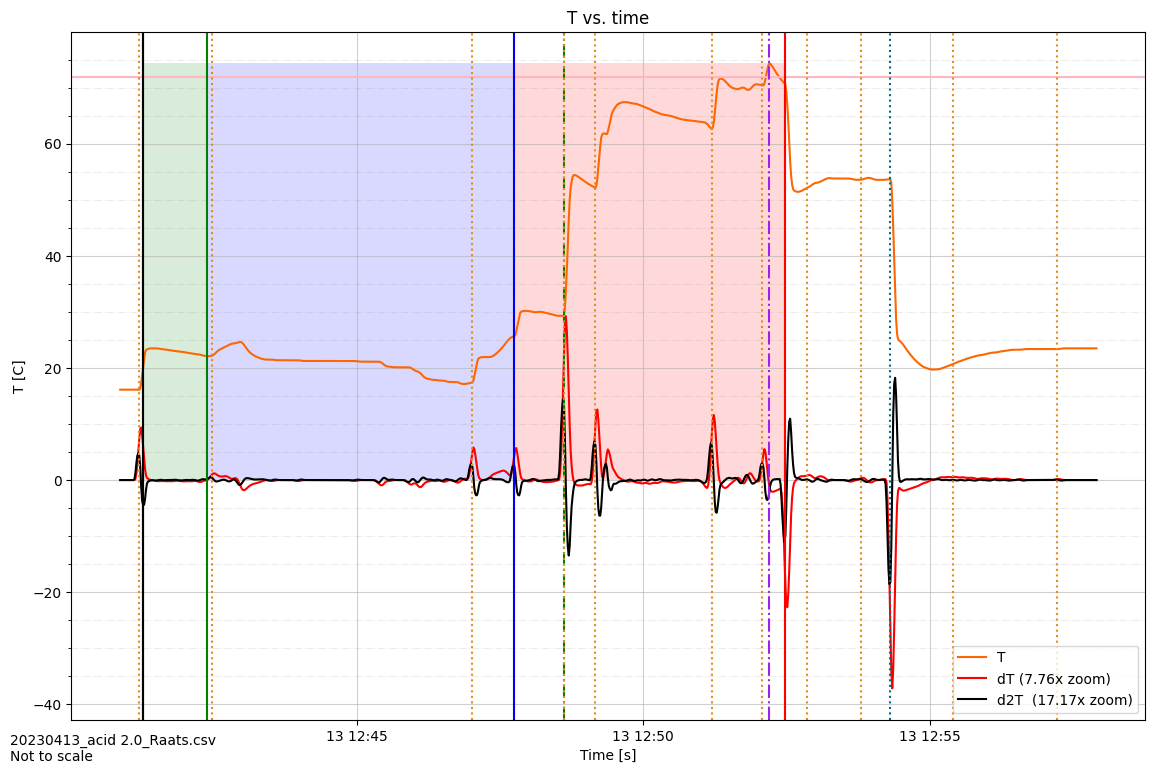

In [ ]:
'''Run the plotting code'''

# Variables to input into the vertical_lines function
dY_max_idx        = dY_absolute_extrema[0]['dY_max idx [#]']
dY_rel_max_idx    = dY_relative_extrema[0]['Index of rel max']
dY_rel_min_idx    = dY_relative_extrema[0]['Index of rel min']

plotInstance      = PlotTemporaryGraphs('t'.upper())
singleplot        = plotInstance.single_graph_plotter()
plot_T_crit_line  = plotInstance.plot_T_crit_line()
plot_vertical_line= plotInstance.plot_vertical_lines(dY_rel_max_idx, dY_rel_min_idx, dY_max_idx)
plot_rectangles   = plotInstance.plot_rectangles()


In [ ]:
# '''[To delete] Class of plotting functionality, copying from it'''

# class Plotter():

#     def single_plotter(self, parameter: str) -> None:
#         '''Makes the plot for a given property, like temp, cond, flow'''
        
#         dY, d2Y = self.setup_derivatives(parameter)
        
#         self.property_1st_letter = parameter[0].upper() # index 0 = 1st letter
#         title                    = self.plot_labels[0][self.property_1st_letter]
#         ylabel                   = self.plot_labels[1][self.property_1st_letter]
#         xlabel                   = 'Time'
#         self.fig.set_size_inches(13, 6.5)
#         self.fig.tight_layout(pad = 3)

#         self.ax.title.set_text(f'{title} vs. time')
#         self.ax.set_ylabel(ylabel)
#         self.ax.set_xlabel(xlabel)        

#         # Gridlines
#         self.ax.grid(which='major', alpha=0.6)
#         self.ax.grid(which='minor', alpha=0.15, color='gray', linestyle='-.')
#         minor_locator_y = MultipleLocator(5)
#         minor_locator_x = MultipleLocator(.0005)
#         self.ax.yaxis.set_minor_locator(minor_locator_y)
#         self.ax.xaxis.set_minor_locator(minor_locator_x)
#         self.fig.gca()

#         # Plot itself
#         self.ax.plot(self.time_index, self.Y, color = plot_color[self.property_1st_letter])
#         zoom  = 0.5 * max(self.Y) / max(abs(dY))
#         zoom2 = 0.25* max(self.Y) / max(abs(d2Y))
#         self.ax.plot(self.time_index, dY  * zoom,  color = 'r')
#         self.ax.plot(self.time_index, d2Y * zoom2, color = 'k')

#         what_param_is_plotted = list(plot_labels[1])[which_param_to_plot]
#         self.ax.legend([ what_param_is_plotted, 'd'+what_param_is_plotted, 'd2'+what_param_is_plotted ])
#         self.fig.canvas.draw()
        
#     def plot_horizontal_lines(self) -> None:
#         self.ax.axhline(y = 0, color = '#FBF1CF', linestyle = '-')  # horizontal 0 line
#         if self.property_1st_letter == 'T':
#             self.ax.axhline(y = 72, color = '#ffb6c1', linestyle = '-') # horizontal line for T=72, only if plotting T

#     def plot_vertical_lines(self, dY_relative_max_idx: np.ndarray, dY_relative_min_idx: np.ndarray, dY_max_idx: np.int64) -> None:

#         post_milk_flush, pre_rinse, hot_rinse, T_max_when, post_rinse, low_C_zone_KPIs = self.phase_identifier()

#         # Drawing a line for highest derivative
#         self.ax.axvline(x = self.time_index[dY_max_idx], color = 'g', linestyle = '-.')

#         # Drawing a line for maxima in dY for all properties
#         for i in dY_relative_max_idx:
#             self.ax.axvline(x = self.time_index[i], color = '#e28c1f', linestyle = ':')

#         # Drawing a line for minima in dY for all properties, but only after maximum temperature
#         for j in dY_relative_min_idx:
#             if self.time_index[j] > T_max_when:
#                 self.ax.axvline(x = self.time_index[j], color = '#026a81', linestyle = ':')

#         self.fig.text(0.01, 0.04, "Not to scale", fontsize = 10)

#         self.ax.axvline(x = post_milk_flush, color = 'k', linestyle = '-')
#         self.ax.axvline(x = pre_rinse, color = 'g', linestyle = '-')
#         self.ax.axvline(x = hot_rinse, color = 'b', linestyle = '-')
#         self.ax.axvline(x = T_max_when, color = '#A020F0', linestyle = '-.')
#         self.ax.axvline(x = post_rinse, color = 'r', linestyle = '-')
#         # self.ax.axvline(x = self.time_index[post_milk_flush], color = 'k', linestyle = '-')

#         # for k in dY2_of_dY_maxima_negative:
#         #     self.ax.axvline(x = self.time_index[k], color = '#fdb6c1', linestyle = '-')

#         # for l in dY2_of_dY_minima_positive:
#         #     self.ax.axvline(x = self.time_index[l], color = '#ffbdc1', linestyle = '-')
        
#         # plt.show()

#     def plot_rectangles(self) -> None:
#         '''Rectangle plotter'''
#         post_milk_flush, pre_rinse, hot_rinse, T_max_when, post_rinse, low_C_zone_KPIs = self.phase_identifier()

#         plt.fill_between((post_milk_flush, pre_rinse),  0, max(self.Y), facecolor= "green", alpha = 0.15)
#         plt.fill_between((pre_rinse, hot_rinse),        0, max(self.Y), facecolor= "blue",  alpha = 0.15)
#         plt.fill_between((post_milk_flush, hot_rinse),  0, max(self.Y), facecolor= "green", alpha = 0.15)
#         plt.fill_between((hot_rinse, post_rinse),       0, max(self.Y), facecolor= "red",   alpha = 0.15)

#         plt.show()


# all_parameters= ['t', 'c', 'f']
# plot_labels   = [{'T': 'T',       'C': 'C',         'F': 'F'},\
#                  {'T': 'T [C]',   'C': 'C [mS/cm]', 'F': 'F [L/min]'} ] # 1) name, 2) name+unit
# plot_color    =  {'T': '#fd6600', 'C': 'g',         'F': '#69A3D8'}

# plotObject = Plotter()#plot_labels, location)
# plotObject.single_plotter(all_parameters[0])
# plotObject.plot_horizontal_lines()
# dY_relative_max_idx, dY_relative_min_idx, dY_max_idx, dY_min_idx, Y_min_max_dict, dYdx, dY_relative_max, dY_relative_min = plotObject.peak_finder()
# plotObject.plot_vertical_lines(dY_relative_max_idx, dY_relative_min_idx, dY_max_idx)
# plotObject.plot_rectangles()

# phases = plotObject.phase_identifier()
# print(phases[-1]['C avg'])
# print(phases[-2])


In [ ]:
'''[ON HOLD to fix later] PLOTTING CLASS'''

# class Setup:
#     '''Base class about plotting with common parameters and methods. Subsequent functions will inherit from it'''

#     COMPARISON_ORDER = 15 #comparing neighbors to find local min/max points
#     WINDOW_SIZE      = 3  #window for smoothing using pandas roll() method

#     def __init__(self, plot_labels, file_name: str):
#         self.plot_labels = plot_labels
#         self.plot_color  = plot_color
#         self.file_name   = file_name
#         # ===========================
#         self.property_1st_letter= None
#         self.Y           = None
#         self.time_index  = None
#         # ===========================
#         self.fig, self.ax= plt.subplots()   #culprit for why a blank graph is made

#     def setup_derivatives(self, parameter: str) -> pd.core.series.Series:
#         '''Setup function to get everything ready for the plotting function'''
#         Y_unsmooth                     = data_cleaning(self.file_name, parameter)
#         self.Y                         = smoothener(Y_unsmooth, window_size = 5)
#         dYdx_unsmooth, d2Ydx2_unsmooth = make_derivatives(self.Y)
#         self.time_index                = self.Y.index

#         # Smoothening the derivatives to get less bumps
#         dYdx   = smoothener(pd.Series(dYdx_unsmooth),   Setup.WINDOW_SIZE)
#         d2Ydx2 = smoothener(pd.Series(d2Ydx2_unsmooth), Setup.WINDOW_SIZE)

#         return dYdx, d2Ydx2


#     def peak_finder(self) -> Tuple[np.ndarray, np.ndarray, np.int64, np.int64, dict, pd.core.series.Series, np.ndarray, np.ndarray]:
#         '''Function that gets peaks for Y and dY'''
#         Y_min_max_dict = relative_points(self.Y, Setup.COMPARISON_ORDER)
#         dY_relative_max_idx, dY_relative_min_idx, dY_max_idx, dY_min_idx, dYdx, dY_relative_max_val, dY_relative_min_val = dY_peak_getter(self.Y, Setup.COMPARISON_ORDER)

#         return dY_relative_max_idx, dY_relative_min_idx, dY_max_idx, dY_min_idx, Y_min_max_dict, dYdx, dY_relative_max_val, dY_relative_min_val
    
#     def get_derivative_peaks_for_parameters(self) -> Tuple[list, list, list, list, list, list]:
#         derivatives = []
#         peaks       = []
#         dY_peaks    = []
#         dY_max_times= []
#         dY_min_times= []
#         Y_series    = []
#         for i, _ in enumerate(all_parameters):
#             dY, d2Y = plotObject.setup_derivatives(all_parameters[i])
#             dY_relative_max_idx, dY_relative_min_idx, dY_max_idx, dY_min_idx, Y_min_max_dict, dYdx, dY_relative_max_val, dY_relative_min_val = self.peak_finder()

#             dY_rel_max_time = self.time_index[dY_relative_max_idx]
#             dY_rel_min_time = self.time_index[dY_relative_min_idx]

#             derivatives.append([dY, d2Y])
#             peaks.append([dY_rel_max_time, dY_rel_min_time, Y_min_max_dict])
#             dY_peaks.append([dYdx, dY_relative_max_val, dY_relative_min_val, dY_relative_max_idx])
            
#             # IMPORTANT: cannot output the time INDICES, especially for T, as input for another function because T has a shorter time index list
#             # due to having empty values (that were removed). So need to have the values in real time 
#             dY_min_time = self.time_index[dY_min_idx]
#             dY_min_times.append(dY_min_time)

#             dY_max_time = self.time_index[dY_max_idx]
#             dY_max_times.append(dY_max_time)

#             Y_series.append(self.Y)

#         return derivatives, peaks, dY_peaks, dY_max_times, dY_min_times, Y_series


# # setupObject = Setup(plot_labels, file_location)


'[ON HOLD to fix later] PLOTTING CLASS'

In [ ]:
'''Creating Excel sheet, make class from this'''

class ExcelSheetMaker:

    EXCEL_EXTENSION = '.xlsx'

    def __init__(self, workbook_name):
        self.workbook_name :str = workbook_name


    def remove_existing_excel_file(self):
        '''Remove existing Excel files in directory'''

        for file in os.listdir("."):
            if file.endswith(self.EXCEL_EXTENSION):
                os.remove(file)
        return None


    def setup_excel_values(self):
        '''Function that makes the values to insert into the Excel workbook
        INPUT: workbook name
        OUTPUT: workbook values, to create a workbook out of'''

        workbook_values = [('A1', 'File name',                                   'A2', Constants.filename),
                           ('B1', 'Day of measurement',                          'B2', post_milk_flush_time.strftime('%Y-%m-%d')),
                           ('C1', 'Start of post-milk flush [RT]',               'C2', post_milk_flush_time.time()),
                           ('D1', 'Start of pre-rinse [RT]',                     'D2', prerinse_time.time()),
                           ('E1', 'Start of hot rinse [RT]',                     'E2', hot_rinse_time.time()),
                           ('F1', 'Time for max T [RT]',                         'F2', Variables.T_max_time.time()),
                           ('G1', 'Start of post-rinse [RT]',                 'G2', post_rinse_time.time()),
                           ('H1', 'Max T [C]',                                   'H2', Variables.T_max),
                           ('I1', f"Avg. T of {Constants.time_interval}s interval with highest T [C]",\
                                                                                 'I2', temp_abs_extrema['T of max time interval [C]']),
                           ('J1', f"Total t for which T>{Constants.T_crit}C [s]",'J2', temp_abs_extrema['Duration for which T > T_crit [s]']),
                           ('K1', 'Avg. C for hot rinse (with water) [mS/cm]',   'K2', rinse_KPIs['C_avg hot rinse [mS/cm]']),
                           ('L1', 'Avg. C for hot rinse (no water) [mS/cm]',     'L2', rinse_KPIs['C_avg hot rinse, no water [mS/cm]']),
                           ('M1', 'Avg. C for hot rinse (no water) [%]',         'M2', rinse_KPIs['C_avg hot rinse, no water [%]']),
                           ('N1', 'Solution type',                               'N2', solution_type),]

        self.workbook_values = workbook_values
        return self.workbook_values


    def make_excel_workbook(self):
        '''Function that creates and saves the Excel workbook
        INPUT: header+cell values
        OUTPUT: None, creates and saves the excel file'''

        open_workbook    = openpyxl.Workbook() #create workbook
        active_worksheet = open_workbook.active #select active worksheet

        # Fill Excel header with values
        header_location= 0
        header_name    = 1
        value_location = 2
        value_number   = 3
        for i, _ in enumerate(self.workbook_values):
            active_worksheet[self.workbook_values[i][header_location]] = self.workbook_values[i][header_name]
            active_worksheet[self.workbook_values[i][value_location]]  = self.workbook_values[i][value_number]

        # Auto-adjust column width
        number_of_columns  = len(self.workbook_values)
        alphabet_characters= string.ascii_uppercase
        for i in alphabet_characters[0 : number_of_columns]:
            active_worksheet.column_dimensions[i].auto_size = True

        open_workbook.save(self.workbook_name) # Save workbook to file

        logger.info(f"Created new Excel file '{self.workbook_name}' in {os.getcwd()}")
        logger.info(self.workbook_values)

        return None


In [ ]:
'''Make Excel sheet'''

excel_sheet_maker = ExcelSheetMaker('important_numbers.xlsx')
remove_excel = excel_sheet_maker.remove_existing_excel_file()
makeExcelFile= excel_sheet_maker.setup_excel_values()
makeExcel    = excel_sheet_maker.make_excel_workbook()


INFO: Created new Excel file 'important_numbers.xlsx' in C:\consumables_cleaning\input
INFO: [('A1', 'File name', 'A2', '20230413_acid 2.0_Raats.csv'), ('B1', 'Day of measurement', 'B2', '2023-04-13'), ('C1', 'Start of post-milk flush [RT]', 'C2', datetime.time(12, 41, 16)), ('D1', 'Start of pre-rinse [RT]', 'D2', datetime.time(12, 42, 23)), ('E1', 'Start of hot rinse [RT]', 'E2', datetime.time(12, 47, 45)), ('F1', 'Time for max T [RT]', 'F2', datetime.time(12, 52, 12)), ('G1', 'Start of of post-rinse [RT]', 'G2', datetime.time(12, 52, 29)), ('H1', 'Max T [C]', 'H2', 74.34582672119141), ('I1', 'Avg. T of 120s interval with highest T [C]', 'I2', 68.37129272013294), ('J1', 'Total t for which T>72.0C [s]', 'J2', 14), ('K1', 'Avg. C for hot rinse (with water) [mS/cm]', 'K2', 1.9767512894353607), ('L1', 'Avg. C for hot rinse (no water) [mS/cm]', 'L2', 1.3371886306767338), ('M1', 'Avg. C for hot rinse (no water) [%]', 'M2', 0.18469456224816763), ('N1', 'Solution type', 'N2', 'acid')]


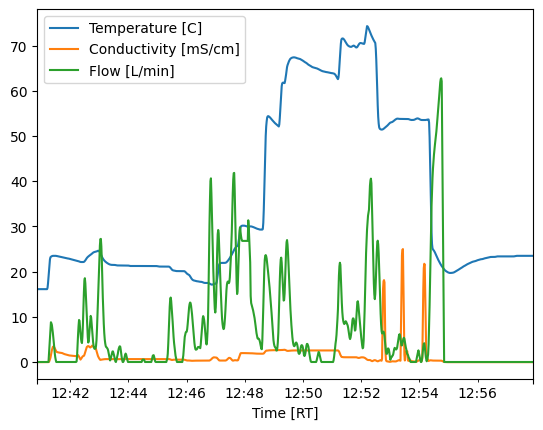

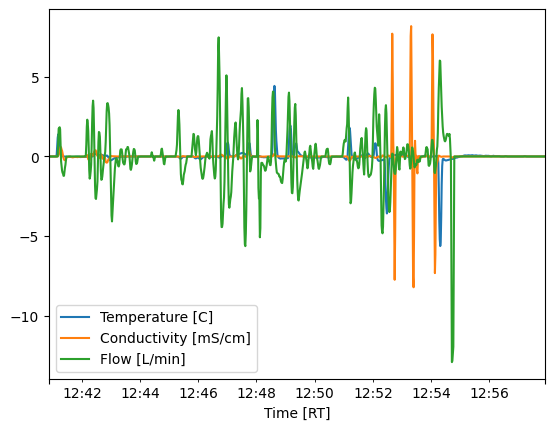

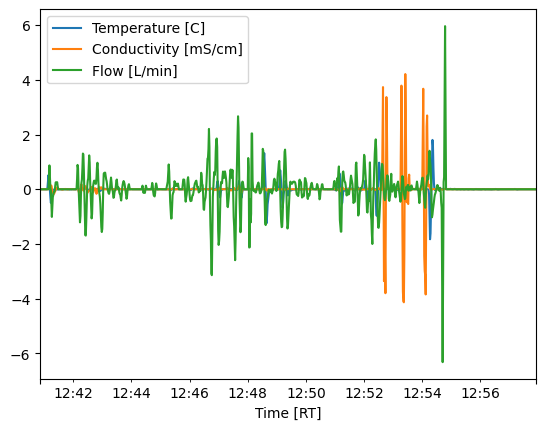

In [ ]:
'''Quick plots'''

df_out = df_smooth
# df_out.iloc[:, 1:4].plot()
df_out.plot(x = df_out.columns[0], y=df_out.columns[1:4])
plt.show()

# df_diff.iloc[:, 1:4].plot()
df_diff.plot(x = df_diff.columns[0], y=df_diff.columns[1:4])
plt.show()

# df_diff2.iloc[:, 1:4].plot()
df_diff2.plot(x = df_diff2.columns[0], y=df_diff2.columns[1:4])
plt.show()

In [ ]:
'''Class that plots graphs to save''' 

class GraphsPlotter():

    COMPARISON_ORDER = 15 #comparing neighbors to find local min/max points
    WINDOW_SIZE      = 3  #window for smoothing using pandas roll() method

    PLOT_PROPERTIES  = {'T': ['T', '#fd6600', 'T [C]'     ], \
                        'C': ['C', 'g',       'C [mS/cm]' ], \
                        'F': ['F', '#69A3D8', 'F [L/min]' ] }

    WHICH_PARAM_TO_PLOT= {'T': 1, '1': '1', \
                          'C': 2, '2': '1', \
                          'F': 3, '3': '1'}


    def __init__(self, param_initial: str):
        self.plot_properties= GraphsPlotter.PLOT_PROPERTIES
        self.filename       = Constants.filename
        self.param_initial  = param_initial
        self.param_to_plot  = GraphsPlotter.WHICH_PARAM_TO_PLOT[param_initial]
        # ===========================
        self.property_1st_letter= None
        self.time_index  = Variables.t_values
        self.Y           = Variables.parameters_dict[param_initial]
        # ===========================
        self.fig, self.ax= plt.subplots()   #culprit for why a blank graph is made


    def single_graph_plotter(self):
        '''Makes the plot for a given property, like temp, cond, flow'''
        
        self.property_1st_letter = self.param_initial 
        
        plot_title = GraphsPlotter.PLOT_PROPERTIES[self.property_1st_letter][0]
        plot_color = GraphsPlotter.PLOT_PROPERTIES[self.property_1st_letter][1]
        plot_ylabel= GraphsPlotter.PLOT_PROPERTIES[self.property_1st_letter][2]
        plot_xlabel= 'Time [s]'
        width_inch = 12
        height_inch= 8
        self.fig.set_size_inches(width_inch, height_inch)
        self.fig.tight_layout(pad = 3)

        self.ax.title.set_text(f'{plot_title} vs. time')
        self.ax.set_ylabel(plot_ylabel)
        self.ax.set_xlabel(plot_xlabel)

        # Gridlines
        self.ax.grid(which='major', alpha=0.6)
        self.ax.grid(which='minor', alpha=0.15, color='gray', linestyle='-.')
        # minor_locator_y = MultipleLocator(5)
        # minor_locator_x = MultipleLocator(.1)
        # self.ax.yaxis.set_minor_locator(minor_locator_y)
        # self.ax.xaxis.set_minor_locator(minor_locator_x)
        self.fig.gca()

        # Plot itself
        x_values_seconds = list(range(1024))
        from datetime import timedelta
        x_tick_labels = [timedelta(seconds=sec) for sec in x_values_seconds]
        self.ax.plot(x_values_seconds, self.Y, color = plot_color)
        plt.xticks(x_values_seconds, x_tick_labels)
# STOPPED HERE, NEED TO MAKE X-AXIS SECONDS, FROM 0 TO 1024


        # self.ax.plot(self.time_index, self.Y, color = plot_color)
        # Variables.df_indices

        what_param_is_plotted = self.param_initial
        self.ax.legend(what_param_is_plotted)

        self.fig.canvas.draw()


    def plot_T_crit_line(self) -> None:
        if self.property_1st_letter == 'T':
            self.ax.axhline(y = Constants.T_crit, color = '#ffb6c1', linestyle = '-') # horizontal line for T=72, only if plotting T

    def plot_rectangles(self) -> None:
        '''Adds rectangles corresponding to each phase into the plot'''

        rect_transparency = 0.15
        plt.fill_between((post_milk_flush_time, prerinse_time),   0, max(self.Y), facecolor= "green", alpha = rect_transparency)
        plt.fill_between((prerinse_time,        hot_rinse_time),  0, max(self.Y), facecolor= "blue",  alpha = rect_transparency)
        plt.fill_between((hot_rinse_time,       post_rinse_time), 0, max(self.Y), facecolor= "red",   alpha = rect_transparency)

        plt.show() # plots the graph, only use at last function


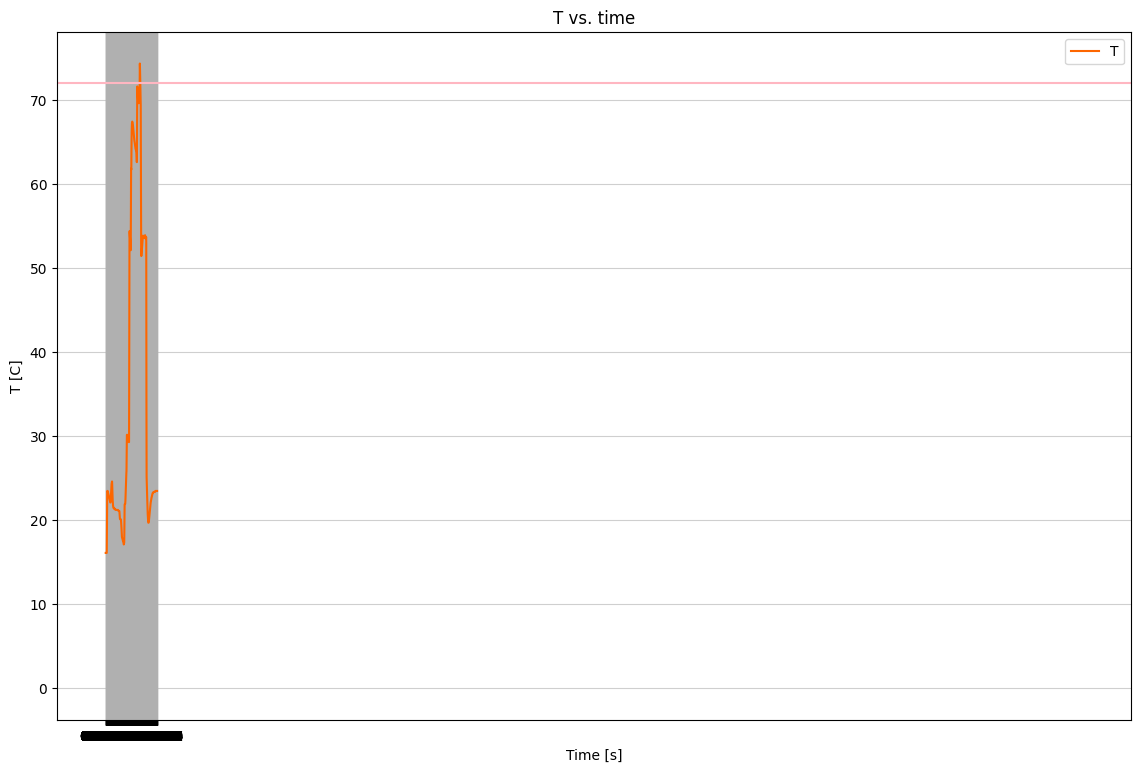

In [ ]:
'''Run the plotting code'''

# Variables to input into the vertical_lines function
dY_max_idx        = dY_absolute_extrema[0]['dY_max idx [#]']
dY_rel_max_idx    = dY_relative_extrema[0]['Index of rel max']
dY_rel_min_idx    = dY_relative_extrema[0]['Index of rel min']

plotInstance      = GraphsPlotter('t'.upper())
singleplot        = plotInstance.single_graph_plotter()
plot_T_crit_line  = plotInstance.plot_T_crit_line()
plot_rectangles   = plotInstance.plot_rectangles()
